# Han et al., 2022 

This Jupyter Notebook was used to analyse and create figures for the ACTA-A Phase 2 manuscript (Han et al. 2022).

## Import libraries

In [1]:
import re 
import os 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 
import gzip
import numpy as np
import scipy
from scipy import sparse
from scipy.optimize import curve_fit, minimize_scalar
import multiprocessing as mp 
mp.set_start_method("fork", force=True)

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
import matplotlib.tri as tri
import matplotlib as mpl
import seaborn as sns

if not os.path.isdir('./manuscript'): 
    os.mkdir('./manuscript')

## Read summary results from previously simulated epidemics

In [2]:
summary_folder = "./summary_json"

all_summary_df = []
for fname in os.listdir(summary_folder):
    with gzip.open('%s/%s'%(summary_folder, fname), "r") as f:
        try: 
            data = f.read()
        except: 
            #print (fname)
            continue 
        summary_dict = json.loads(data.decode('utf-8'))
    row_id = fname.replace(".gz", "")
    summary_dict['id'] = row_id
    if re.search('check', row_id): 
        #print (row_id)
        summary_dict['check'] = 1
    
    all_summary_df.append(summary_dict)
all_summary_df = pd.DataFrame.from_dict(all_summary_df)
all_summary_df.head()

,mean_n_deaths,sd_n_deaths,mean_length_of_infectious_period,mean_Reff_temp,sd_Reff_temp,mean_Sus_temp,sd_Sus_temp,mean_Exp_temp,sd_Exp_temp,mean_Inf_temp,sd_Inf_temp,mean_Rec_temp,sd_Rec_temp,mean_Dea_temp,sd_Dea_temp,mean_n_sec_trans,sd_n_sec_trans,mean_f_sec_trans,sd_f_sec_trans,mean_n_sec_trans_household,sd_n_sec_trans_household,mean_f_sec_trans_household,sd_f_sec_trans_household,mean_n_sec_trans_school,sd_n_sec_trans_school,mean_f_sec_trans_school,sd_f_sec_trans_school,mean_n_sec_trans_workplace_formal,sd_n_sec_trans_workplace_formal,mean_f_sec_trans_workplace_formal,sd_f_sec_trans_workplace_formal,mean_n_sec_trans_workplace_informal,sd_n_sec_trans_workplace_informal,mean_f_sec_trans_workplace_informal,sd_f_sec_trans_workplace_informal,mean_n_sec_trans_community,sd_n_sec_trans_community,mean_f_sec_trans_community,sd_f_sec_trans_community,mean_n_sec_trans_church,sd_n_sec_trans_church,mean_f_sec_trans_church,sd_f_sec_trans_church,mean_n_inf_person_days,sd_n_inf_person_days,mean_n_inf_person_days_averted,sd_n_inf_person_days_averted,mean_f_inf_person_days_averted,sd_f_inf_person_days_averted,mean_n_inf_person_days_averted_isolation,sd_n_inf_person_days_averted_isolation,mean_f_inf_person_days_averted_isolation,sd_f_inf_person_days_averted_isolation,mean_n_inf_person_days_averted_quarantine,sd_n_inf_person_days_averted_quarantine,mean_f_inf_person_days_averted_quarantine,sd_f_inf_person_days_averted_quarantine,mean_n_inf_person_days_averted_hospitalisation,sd_n_inf_person_days_averted_hospitalisation,mean_f_inf_person_days_averted_hospitalisation,sd_f_inf_person_days_averted_hospitalisation,mean_n_inf_person_days_averted_self_isolation,sd_n_inf_person_days_averted_self_isolation,mean_f_inf_person_days_averted_self_isolation,sd_f_inf_person_days_averted_self_isolation,mean_spillover_household_school,sd_spillover_household_school,mean_spillover_household_workplace_formal,sd_spillover_household_workplace_formal,mean_spillover_household_workplace_informal,sd_spillover_household_workplace_informal,mean_spillover_household_community,sd_spillover_household_community,mean_spillover_household_church,sd_spillover_household_church,mean_spillover_school_household,sd_spillover_school_household,mean_spillover_school_school_class,sd_spillover_school_school_class,mean_spillover_school_workplace_formal,sd_spillover_school_workplace_formal,mean_spillover_school_workplace_informal,sd_spillover_school_workplace_informal,mean_spillover_school_community,sd_spillover_school_community,mean_spillover_school_church,sd_spillover_school_church,mean_spillover_school_class_school,sd_spillover_school_class_school,mean_spillover_workplace_formal_household,sd_spillover_workplace_formal_household,mean_spillover_workplace_formal_school,sd_spillover_workplace_formal_school,mean_spillover_workplace_formal_workplace_informal,sd_spillover_workplace_formal_workplace_informal,mean_spillover_workplace_formal_community,sd_spillover_workplace_formal_community,mean_spillover_workplace_formal_church,sd_spillover_workplace_formal_church,mean_spillover_workplace_informal_household,sd_spillover_workplace_informal_household,mean_spillover_workplace_informal_school,sd_spillover_workplace_informal_school,mean_spillover_workplace_informal_workplace_formal,sd_spillover_workplace_informal_workplace_formal,mean_spillover_workplace_informal_community,sd_spillover_workplace_informal_community,mean_spillover_workplace_informal_church,sd_spillover_workplace_informal_church,mean_spillover_community_household,sd_spillover_community_household,mean_spillover_community_school,sd_spillover_community_school,mean_spillover_community_workplace_formal,sd_spillover_community_workplace_formal,mean_spillover_community_workplace_informal,sd_spillover_community_workplace_informal,mean_spillover_community_church,sd_spillover_community_church,mean_spillover_church_household,sd_spillover_church_household,mean_spillover_church_school,sd_spillover_church_school,mean_spillover_church_workplace_formal,sd_sp

In [3]:
# no testing
zero_summary_df = all_summary_df[all_summary_df['number_of_rdt_per_100k_per_day']==0].copy() 
# symptomatic 
symp_summary_df = all_summary_df[(all_summary_df['setting']=='baseline')&(all_summary_df['number_of_rdt_per_100k_per_day']>0)].copy()
# comm screening 
comm_summary_df = all_summary_df[all_summary_df['setting']!='baseline']

## Symptomatic testing demand

,R0,quar_bool,N_enough,dydx
0,0.9,0,200,1772.300000
1,1.1,0,200,19807.000000
2,1.2,0,400,19371.679976
3,1.5,0,2000,3655.364132
4,2.0,0,3000,1149.126515
5,2.5,0,5000,401.149730
6,3.0,0,5000,216.254084
7,0.9,1,200,2204.999998
8,1.1,1,200,23443.700162
9,1.2,1,400,23250.488502


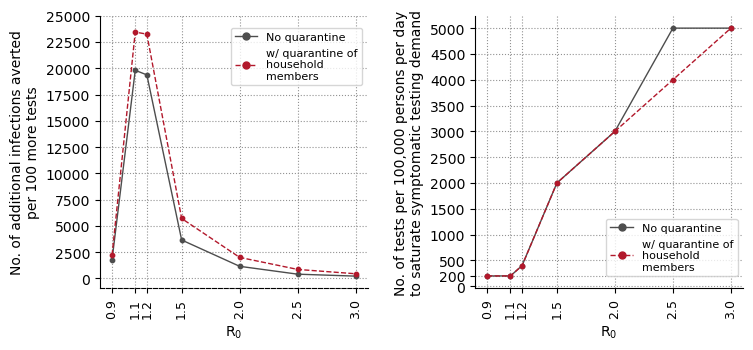

In [5]:
def func(x, m, c):
    return m*x + c

symp_improvement_df = []
reg_symp_summary_df = symp_summary_df[pd.isna(symp_summary_df['init_immune_prop'])].copy()

for q in np.arange(2): 
    q_fdf = reg_symp_summary_df[reg_symp_summary_df['quarantine_hcf_bool']==q].copy()

    for R0 in np.sort(q_fdf['R0'].unique()):
        R0_q_fdf = q_fdf[q_fdf['R0']==R0].copy().sort_values(by='number_of_rdt_per_100k_per_day')
        
        x_arr = R0_q_fdf['number_of_rdt_per_100k_per_day'].to_numpy()
        y_arr = R0_q_fdf['mean_n_sec_trans'].to_numpy()
        y_sd_arr = R0_q_fdf['sd_n_sec_trans'].to_numpy()            
        z_arr = R0_q_fdf['mean_infectee_per_untested_infector'].to_numpy()
        idx_arr = np.arange(len(z_arr))
        last_idx = idx_arr[~np.isnan(z_arr)][-1] + 1     
        last_idx += 1

        zero_y = zero_summary_df[(zero_summary_df['R0']==R0)&(pd.isna(zero_summary_df['init_immune_prop']))]['mean_n_sec_trans'].iloc[0]
        zero_y_sd = zero_summary_df[(zero_summary_df['R0']==R0)&(pd.isna(zero_summary_df['init_immune_prop']))]['sd_n_sec_trans'].iloc[0]

        y_arr = zero_y - y_arr
        y_sd_arr = 3 * np.sqrt(zero_y_sd ** 2 + y_sd_arr ** 2)

        #plt.errorbar(x_arr[:last_idx], y_arr[:last_idx], y_sd[:last_idx])
        popt, pcov = curve_fit(func, [0] + list(x_arr[:last_idx]), [0] + list(y_arr[:last_idx]))
        """plt.scatter(x_arr[:last_idx], y_arr[:last_idx])
        try: 
            plt.plot(x_arr[:last_idx], func(x_arr[:last_idx], *popt))
        except: 
            pass 
        plt.show()"""
        
        residuals = y_arr[:last_idx] - func(x_arr[:last_idx], *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y_arr[:last_idx]-np.mean(y_arr[:last_idx]))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        m, c = popt
        symp_improvement_df.append({'R0':1.5 if R0 == 1.6 else R0, 'quar_bool':q, 
                                    'N_enough':x_arr[:last_idx][-1], 'dydx':abs(m)*100})
        
symp_improvement_df = pd.DataFrame.from_dict(symp_improvement_df)
#symp_improvement_df.to_csv("./figures/symp_improvement_df.csv", index=False)
display (symp_improvement_df)

with plt.style.context("default"): 
    fig = plt.figure(figsize=(8.3, 11.8 * 0.3))
    gs = GridSpec(nrows=1, ncols=2, wspace=0.4)
    ####
    ax = fig.add_subplot(gs[0])
    for q in np.arange(2): 
        fdf = symp_improvement_df[symp_improvement_df['quar_bool']==q]
        ax.plot(fdf['R0'], fdf['dydx'], ls='--' if q > 0 else '-', lw=1., color='#b2182b' if q > 0 else '#4d4d4d', zorder=100)
        ax.scatter(fdf['R0'], fdf['dydx'], s=10, color='#b2182b' if q > 0 else '#4d4d4d', zorder=100)
    ax.set_xlabel('R$_0$')
    for axis in ['top', 'right']: 
        ax.spines[axis].set_visible(False)
    ax.spines['bottom'].set_linestyle('--')
    ax.set_ylabel('No. of additional infections averted\nper 100 more tests')
    ax.set_xticks(np.sort(np.unique(fdf['R0'])))
    ax.tick_params(axis='x', rotation=90, labelsize=9)
    #ax.axvspan(0.9, 1.2, facecolor='#542788', alpha=0.2, zorder=-200)    
    ax.grid(axis='both', ls='dotted', lw=0.8, c="#929292", alpha=1.)
    ax.set_yticks(np.linspace(0, 25000, 11))
    
    # fig legend 
    legend_elements = [Line2D([0], [0], marker='o', color='#4d4d4d', lw=1., ls='-', 
                               label="No quarantine", markersize=5),
                      Line2D([0], [0], marker='o', color='#b2182b', lw=1., ls='--', 
                               label="w/ quarantine of\nhousehold\nmembers", markersize=5)]
    ax.legend(handles=legend_elements, bbox_to_anchor=(1., 0.85), loc="center right", ncol=1, fontsize=8,)
    
    #### 
    ax = fig.add_subplot(gs[1])
    for q in np.arange(2): 
        fdf = symp_improvement_df[symp_improvement_df['quar_bool']==q]
        ax.plot(fdf['R0'], fdf['N_enough'], ls='--' if q > 0 else '-', lw=1., color='#b2182b' if q > 0 else '#4d4d4d', zorder=100)
        ax.scatter(fdf['R0'], fdf['N_enough'], s=10, color='#b2182b' if q > 0 else '#4d4d4d', zorder=100)
    ax.set_xlabel('R$_0$')        
    for axis in ['top', 'right']: 
        ax.spines[axis].set_visible(False)
    ax.set_ylabel('No. of tests per 100,000 persons per day\nto saturate symptomatic testing demand')
    ax.set_yticks(np.sort([200] + list(np.arange(0, 5500, 500))))
    ax.set_xticks(np.sort(np.unique(fdf['R0'])))
    ax.tick_params(axis='x', rotation=90, labelsize=9)
    #ax.axvspan(0.9, 1.2, facecolor='#542788', alpha=0.2, zorder=-200)
    ax.grid(axis='both', ls='dotted', lw=.8, c="#929292", alpha=1., zorder=-100)    
    
    # fig legend 
    legend_elements = [Line2D([0], [0], marker='o', color='#4d4d4d', lw=1., ls='-', 
                               label="No quarantine", markersize=5),
                      Line2D([0], [0], marker='o', color='#b2182b', lw=1., ls='--', 
                               label="w/ quarantine of\nhousehold\nmembers", markersize=5)]
    ax.legend(handles=legend_elements, bbox_to_anchor=(1., 0.15), loc="center right", ncol=1, fontsize=8,)
    
    plt.show()

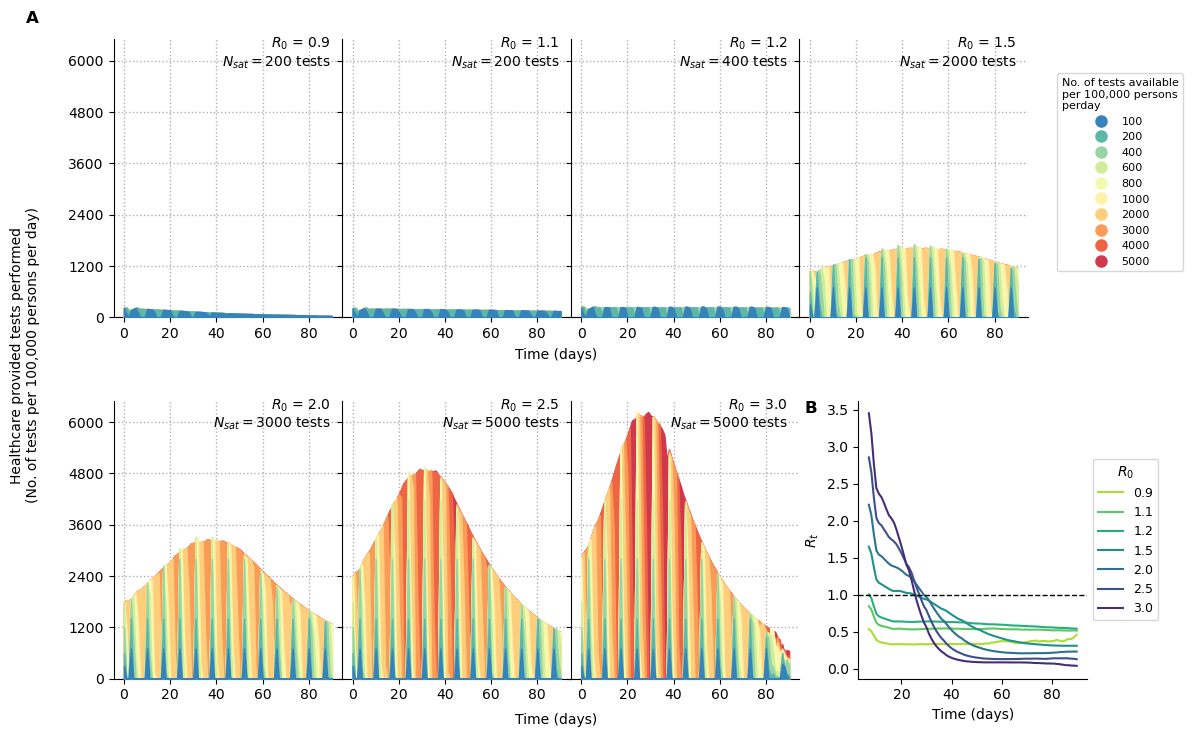

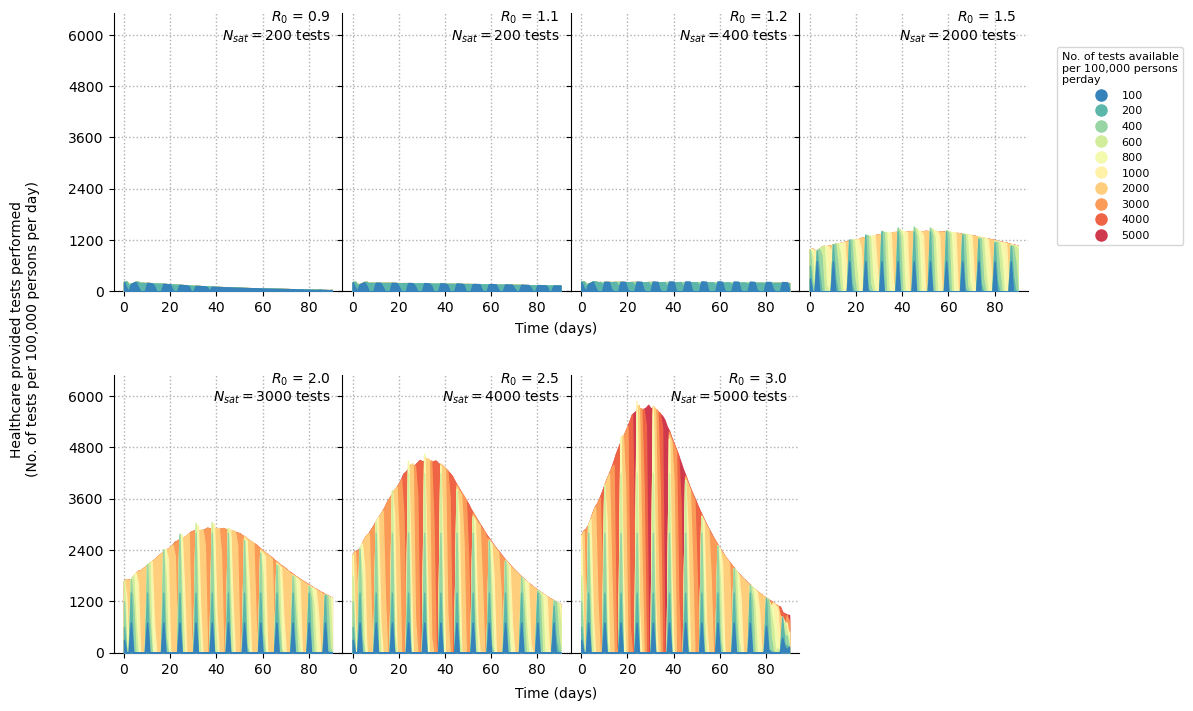

In [6]:
with plt.style.context("default"): 
    # regular
    reg_symp_summary_df = symp_summary_df[pd.isna(symp_summary_df['init_immune_prop'])].copy()
    
    for quarantine_bool in np.arange(2): 
        
        # filter data 
        quar_reg_symp_summary_df = reg_symp_summary_df[reg_symp_summary_df['quarantine_hcf_bool']==quarantine_bool]
        #display (quar_reg_symp_summary_df)
        N_tests_arr = np.sort(quar_reg_symp_summary_df['number_of_rdt_per_100k_per_day'].unique())
        cmap = sns.color_palette('Spectral_r', len(N_tests_arr))
        R0_arr = np.sort(quar_reg_symp_summary_df['R0'].unique())
        
        fig = plt.figure(figsize=(11.8, 8.3))
        gs = GridSpec(nrows=2, ncols=4, wspace=0., hspace=0.3)
        
        for r, R0 in enumerate([0.9, 1.1, 1.2, 1.6, 2.0, 2.5, 3.0]):
            
            x, y = int(r/4), r%4
            
            ax = fig.add_subplot(gs[x, y]) 
            """ax2 = ax.twinx()"""
            
            mask_r = quar_reg_symp_summary_df['R0'] == R0
            
            for n, Ntests in enumerate(N_tests_arr): 
                mask_n = quar_reg_symp_summary_df['number_of_rdt_per_100k_per_day'] == Ntests
                
                # plot symptomatic testing performed 
                fdf = quar_reg_symp_summary_df[mask_n&mask_r]
                try: 
                    #ax.plot(fdf['mean_symp_tests_temp'].iloc[0], color=cmap[n], lw=1., zorder=100-n)
                    ax.fill_between(np.arange(len(fdf['mean_symp_tests_temp'].iloc[0])), 
                                    y1=[0] * len(fdf['mean_symp_tests_temp'].iloc[0]), 
                                    y2=np.array(fdf['mean_symp_tests_temp'].iloc[0])/10, 
                                    color=cmap[n], alpha=1., zorder=50-n)
                except: 
                    print (Ntests, R0)
                    continue 
                
                # plot epidemic curve 
                sus_arr = np.array(fdf['mean_Sus_temp'].iloc[0])
                sus_arr[1:] = sus_arr[:-1] - sus_arr[1:]
                sus_arr[0] = sus_arr[0] - 1e6*.99
                """ax2.plot(sus_arr, ls='--', lw=1., color=cmap[n])"""
                
            ax.set_ylim(0., 6500)
            ax.set_yticks(np.linspace(0, 6000, 6))
            
            try: 
                N_enough = symp_improvement_df[(symp_improvement_df['R0']==R0)&(symp_improvement_df['quar_bool']==quarantine_bool)]['N_enough'].iloc[0]
            except: 
                N_enough = symp_improvement_df[(symp_improvement_df['R0']==1.5)&(symp_improvement_df['quar_bool']==quarantine_bool)]['N_enough'].iloc[0]
            
            ax.grid(axis='both', ls='dotted', zorder=-100, lw=1., alpha=1.)
            """if x == 1 and y == 1:
                ax.set_xlabel('Time (days)')"""
            
            for axis in ['top', 'right']: 
                ax.spines[axis].set_visible(False)
                
            """ax2.set_ylim(0., 65000)
            if x == 3: 
                ax2.set_yticks(np.linspace(0, 50000, 6))
            else: 
                ax2.set_yticks(np.linspace(0, 60000, 7))
            for axis in ['left', 'top']: 
                ax2.spines[axis].set_visible(False)"""
                
            if y > 0: 
                ax.set_yticklabels([])
            ax.text(s="$R_0$ = %.1f\n"%(1.5 if R0 == 1.6 else R0) + "$N_{sat} = $%i tests"%(N_enough), x=.95, y=.95, transform=ax.transAxes, ha='right', va='center')
            
        fig.text(s='Healthcare provided tests performed\n(No. of tests per 100,000 persons per day)', x=0.05, y=0.5, ha='center', va='center', rotation=90)
        """fig.text(s='Number of infected persons', x=.99, y=0.5, ha='center', va='center', rotation=270)"""
        fig.text(s='Time (days)', x=0.5, y=0.06, ha='center', va='center')
        fig.text(s='Time (days)', x=0.5, y=0.5, ha='center', va='center')
        
        # legend 
        legend_elements = []
        for n, Ntests in enumerate(N_tests_arr): 
            legend_elements.append(Line2D([0], [0], marker='o', color=cmap[n], lw=0., label=Ntests, markerfacecolor=cmap[n], markersize=8))
        legend = fig.legend(handles=legend_elements, bbox_to_anchor=(.92, 0.72), loc="center left", ncol=1, fontsize=8, title="No. of tests available\nper 100,000 persons\nperday")
        plt.setp(legend.get_title(),fontsize=8)
        
        if quarantine_bool == 0:
            
            ### add Rt subplot ### 
            ax = fig.add_subplot(gs[1,3])
            
            box = ax.get_position()
            box.x0 = box.x0 + 0.05
            box.x1 = box.x1 + 0.05
            ax.set_position(box)

            reg_symp_summary_df = symp_summary_df[pd.isna(symp_summary_df['init_immune_prop'])].copy()
            quar_reg_symp_summary_df = reg_symp_summary_df[reg_symp_summary_df['quarantine_hcf_bool']==0]
            cmap = sns.color_palette('viridis_r', len(quar_reg_symp_summary_df['R0'].unique()))

            for r, R0 in enumerate(np.sort(quar_reg_symp_summary_df['R0'].unique())): 
                R0_quar_reg_symp_summary_df = quar_reg_symp_summary_df[quar_reg_symp_summary_df['R0']==R0]
                fdf = R0_quar_reg_symp_summary_df[R0_quar_reg_symp_summary_df['number_of_rdt_per_100k_per_day']==100]

                Rt_arr = np.array(fdf['mean_Reff_temp'].iloc[0])
                N_period = len(Rt_arr)

                avg_Rt_arr = np.array([Rt_arr[i-7:i].mean() for i in np.arange(7, N_period)])

                #ax.scatter(np.arange(7, len(Rt_arr)), Rt_arr[7:], color=cmap[r], s=10)
                ax.plot(np.arange(7, len(Rt_arr)), avg_Rt_arr, color=cmap[r], label=1.5 if R0 == 1.6 else R0)

            for axis in ['top', 'right']: 
                ax.spines[axis].set_visible(False)
            ax.legend(title='$R_0$', fontsize=9, loc='center left', bbox_to_anchor=(1., 0.5))
            ax.set_xlabel("Time (days)")
            ax.set_ylabel('$R_t$')

            ax.axhline(1., c='k', lw=1., ls='--')
            
            ######################
            
            # annotate 
            fig.text(s=r"$\bf{A}$", x=0.05, y=.9, fontsize=12,)
            fig.text(s=r"$\bf{B}$", x=0.71, y=.43, fontsize=12,)
            
            plt.savefig('./manuscript/Figure4.png'%(quarantine_bool), dpi=330, bbox_inches='tight')
        else: 
            plt.savefig('./manuscript/SFigure2.png'%(quarantine_bool), dpi=330, bbox_inches='tight')            
        
        plt.show()

## What if we set aside 85% of all available tests for community self-testing?

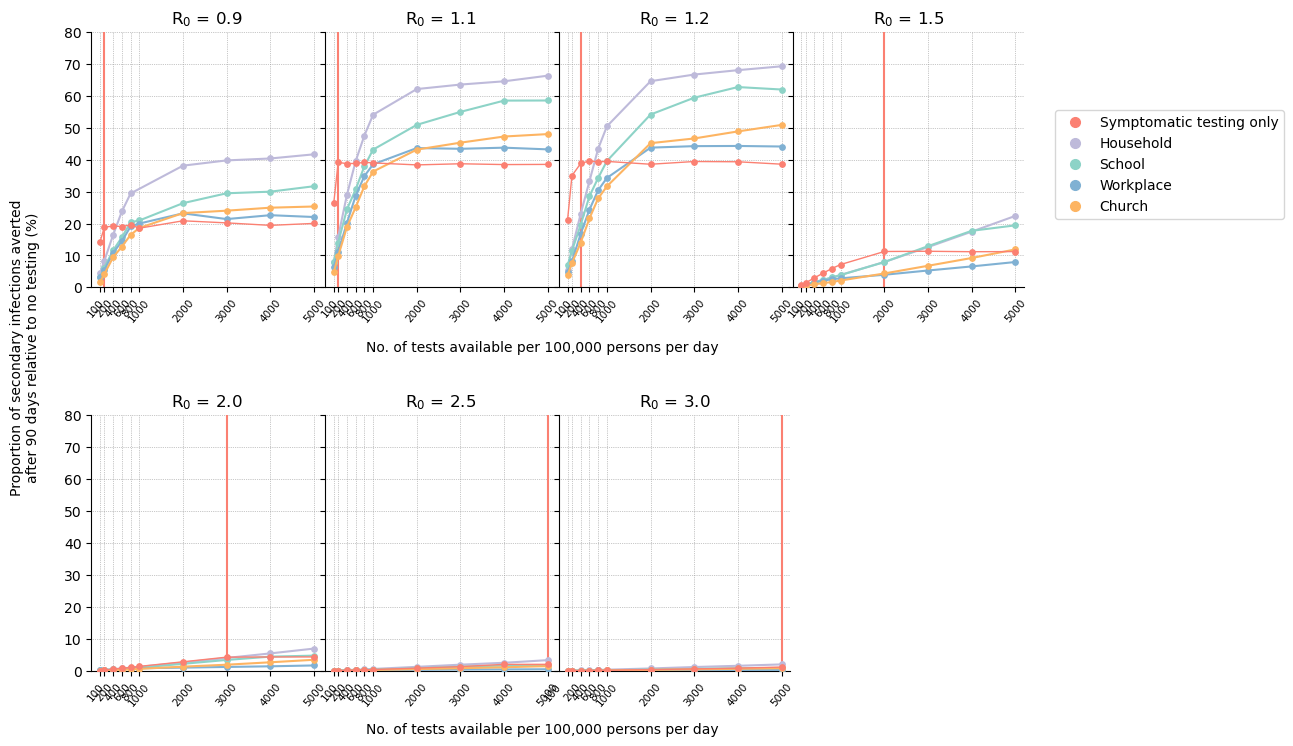

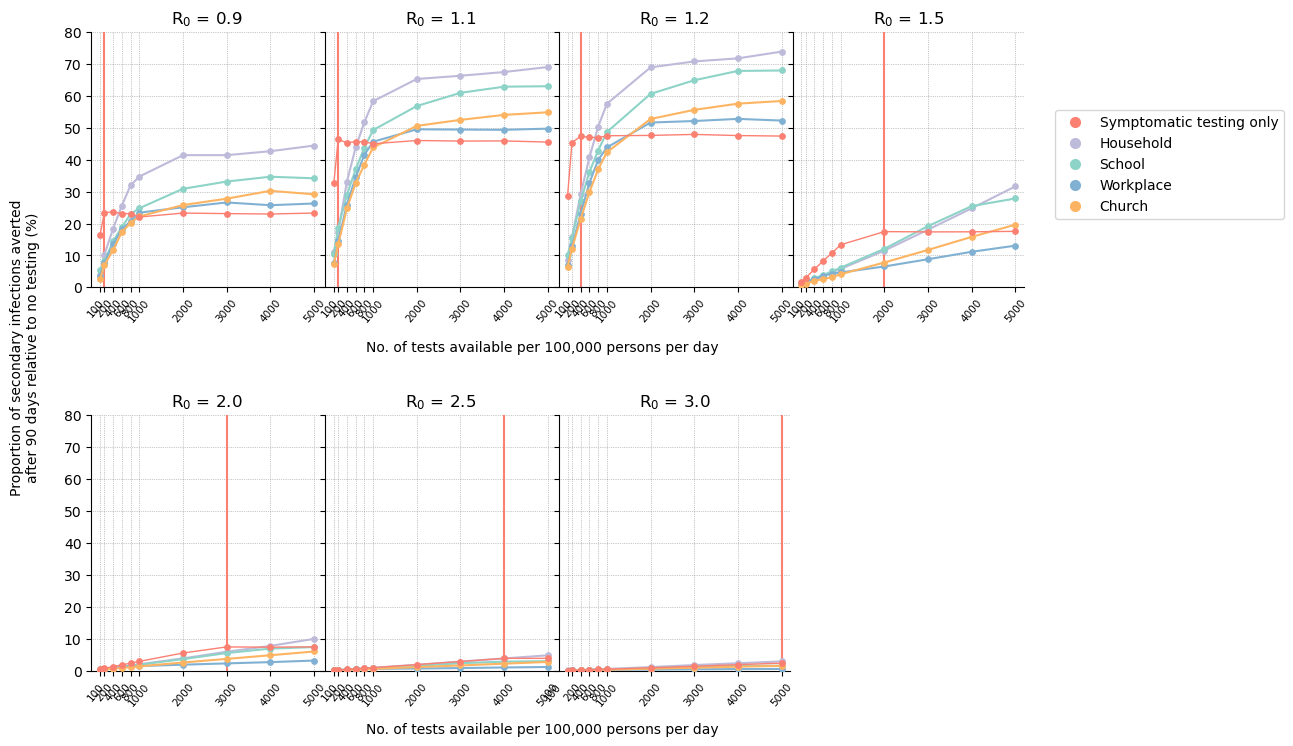

In [7]:
setting_cmap = {setting:sns.color_palette("Set3", 6)[s] for s, setting in enumerate(['school', '', 'household', 'baseline', 'workplace', 'church'])}

df = []
compare_impact_arr = np.zeros((2, len(comm_summary_df['R0'].unique()), len(comm_summary_df['number_of_rdt_per_100k_per_day'].unique())), dtype=float)

with plt.style.context("default"): 
    
    for q in np.arange(2): 
        
        fig = plt.figure(figsize=(11.8*1.02, 8.3))
        gs = GridSpec(nrows=2, ncols=4, hspace=0.5, wspace=0.01)
    
        q_symp_improvement_df = symp_improvement_df[symp_improvement_df['quar_bool']==q]
        
        for r, R0 in enumerate(np.sort(comm_summary_df['R0'].unique())): 
            
            if R0 == 1.6: 
                R0_q_symp_improvement_df = q_symp_improvement_df[q_symp_improvement_df['R0']==1.5]
            else: 
                R0_q_symp_improvement_df = q_symp_improvement_df[q_symp_improvement_df['R0']==R0]
            
            axI, axJ = int(r/4), (r%4)
            ax = fig.add_subplot(gs[axI, axJ])
            ax.set_title('R$_0$ = %.1f'%(1.5 if R0 ==1.6 else R0))

            R0_comm_summary_df = comm_summary_df[(comm_summary_df['R0'] == R0)&(comm_summary_df['quarantine_hcf_bool']==q)&(comm_summary_df['check']==1)].sort_values(by="number_of_rdt_per_100k_per_day")
            R0_symp_summary_df = symp_summary_df[(symp_summary_df['R0'] == R0)&(symp_summary_df['quarantine_hcf_bool']==q)&(pd.isna(symp_summary_df['init_immune_prop']))].sort_values(by="number_of_rdt_per_100k_per_day")
            
            R0_zero_summary_df = zero_summary_df[(zero_summary_df['R0'] == R0)&(pd.isna(zero_summary_df['init_immune_prop']))]
            # no testing baseline 
            zero_y = R0_zero_summary_df['mean_n_sec_trans'].iloc[0]
            
            df.append({"N":0, "y":zero_y})
            
            # plot symptomatic result 
            symp_x_arr = R0_symp_summary_df['number_of_rdt_per_100k_per_day'].to_numpy()
            symp_y_arr = (zero_y - R0_symp_summary_df['mean_n_sec_trans'].to_numpy())/zero_y
            compare_impact_arr[q,r,:] = symp_y_arr
            
            for _, y in enumerate(symp_y_arr): 
                df.append({'N':symp_x_arr[_], 'setting':'symp', 'y':abs((y*zero_y) - zero_y)})
            
            #symp_mask = (symp_x_arr<=100)|(symp_x_arr>=1000)
            symp_x_arr = symp_x_arr#[symp_mask]
            symp_y_arr = symp_y_arr#[symp_mask]
            
            ax.plot(symp_x_arr, 100 * symp_y_arr, ls='-', lw=1., color=setting_cmap['baseline'], zorder=100)
            ax.scatter(symp_x_arr, 100 * symp_y_arr, marker='o', s=15, color=setting_cmap['baseline'], zorder=100)
            
            ax.axvline(R0_q_symp_improvement_df['N_enough'].iloc[0], color=setting_cmap['baseline'],)
            
            # plot comm result 
            for setting in ['household', 'school', 'workplace', 'church']: 
                setting_R0_comm_summary_df = R0_comm_summary_df[R0_comm_summary_df['setting']==setting]
                if len(setting_R0_comm_summary_df) == 0: 
                    continue 
                
                for d, density in enumerate(['low', 'high_fixed']):
                    fdf = setting_R0_comm_summary_df[setting_R0_comm_summary_df["density"]==density]
                    
                    comm_x_arr = fdf['number_of_rdt_per_100k_per_day'].to_numpy()
                    #comm_mask = (comm_x_arr<=100)|(comm_x_arr>=1000)
                    
                    comm_y_arr = fdf['mean_n_sec_trans'].to_numpy()#[comm_mask]
                    comm_y_sd_arr = fdf['sd_n_sec_trans'].to_numpy()#[comm_mask]
                    #comm_x_arr = comm_x_arr[comm_mask]
                    
                    for _, y in enumerate(comm_y_arr): 
                        df.append({'N':comm_x_arr[_], 'setting':setting, 'y':y})
                    
                    plot_y_arr = (zero_y - comm_y_arr)/zero_y
                    
                    ax.plot(comm_x_arr, 100 * plot_y_arr, ls='--' if d > 0 else '-', color=setting_cmap[setting], zorder=50, lw=1.5,)
                    ax.scatter(comm_x_arr, 100 * plot_y_arr, marker='x' if d > 0 else 'o', s=30 if d > 0 else 15, color=setting_cmap[setting], zorder=50)
            
            ax.set_ylim(0., 80)
            
            ax.set_xticks([100, 200, 400, 600, 800, 1000, 2000, 3000, 4000, 5000])
            ax.set_xlim(-100, 5200)
            ax.grid(axis='both', ls='dotted', lw=0.5, c='#929292', zorder=-100)
            ax.tick_params(axis='x', rotation=90, labelsize=7.5)
            
            if axJ > 0: 
                ax.set_yticklabels([])
            
            for axis in ['top', 'right']: 
                ax.spines[axis].set_visible(False)
                
            # apply offset transform to all x ticklabels.
            for l, label in enumerate(ax.xaxis.get_majorticklabels()):
                if l == 0:
                    dx = 3/72.; dy = 0/72. 
                    offset = mpl.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
                    label.set_transform(label.get_transform() - offset)
            
            plt.setp(ax.get_xticklabels(), rotation=50, horizontalalignment='center')
                
        fig.text(s='No. of tests available per 100,000 persons per day', x=0.5, y=0.04, ha='center', va='center', fontsize=10)
        fig.text(s='No. of tests available per 100,000 persons per day', x=0.5, y=0.5, ha='center', va='center', fontsize=10)  
        fig.text(s='Proportion of secondary infections averted\nafter 90 days relative to no testing (%)', x=0.07, y=0.5,
                 rotation=90, ha='center', va='center', fontsize=10)          
        
        # legend 
        legend_elements = []
        for s, setting in zip(['baseline', 'household', 'school', 'workplace', 'church'], ['Symptomatic testing only', 'Household', 'School', 'Workplace', 'Church']):
            legend_elements.append(Line2D([0], [0], marker='o', color=setting_cmap[s], lw=0., label=setting, 
                                          markerfacecolor=setting_cmap[s], markersize=7))
        legend = fig.legend(handles=legend_elements, bbox_to_anchor=(.92, 0.72), loc="center left", ncol=1, fontsize=10,)
        
        plt.setp(ax.get_xticklabels()[0], rotation=50, horizontalalignment='right')
        plt.setp(ax.get_xticklabels()[1:], rotation=50, horizontalalignment='center')
        
        """if q > 0: 
            add_ax = plt.axes([0.8, 0.1, 0.25, 0.35])
            
            cmap = sns.color_palette('viridis', len(comm_summary_df['R0'].unique()))
            for r, R0 in enumerate(np.sort(comm_summary_df['R0'].unique())): 
                add_ax.scatter(np.sort(comm_summary_df['number_of_rdt_per_100k_per_day'].unique()),
                           100 * (compare_impact_arr[1,r,:] - compare_impact_arr[0,r,:]), 
                           color=cmap[r], s=40, marker='.')
                add_ax.plot(np.sort(comm_summary_df['number_of_rdt_per_100k_per_day'].unique()), 
                        100 * (compare_impact_arr[1,r,:] - compare_impact_arr[0,r,:]),
                        color=cmap[r], label="%.1f"%R0,)

            add_ax.set_xticks([100, 200, 400, 600, 800, 1000, 2000, 3000, 4000, 5000])
            add_ax.set_xlim(-100, 5200)
            add_ax.grid(axis='both', ls='dotted', lw=0.5, c='#929292', zorder=-100)
            add_ax.tick_params(axis='x', rotation=90, labelsize=7.5)

            for axis in ['top', 'right']: 
                add_ax.spines[axis].set_visible(False)

            # apply offset transform to all x ticklabels.
            for l, label in enumerate(add_ax.xaxis.get_majorticklabels()):
                if l == 0:
                    dx = 3/72.; dy = 0/72. 
                    offset = mpl.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
                    label.set_transform(label.get_transform() - offset)

            plt.setp(add_ax.get_xticklabels(), rotation=50, horizontalalignment='center')

            add_ax.set_xlabel('No. of tests available per 100,000 persons per day', fontsize=10)
            add_ax.set_ylabel("Improvement in proportion of infections averted\ndue to household members' quarantine(%)", fontsize=10) 
            add_ax.legend(title='$R_0$', fontsize=9, loc='center left', bbox_to_anchor=(1., 0.5))
            
            fig.text(s=r'$\bf{A}$', x=0.07, y=.9, fontsize=12)
            fig.text(s=r'$\bf{B}$', x=0.72, y=.48, fontsize=12)"""
        
        #plt.savefig('./figures/testing_comm_useless.png'%(q), bbox_inches="tight", dpi=330)
        if q == 0: 
            plt.savefig('./manuscript/Figure3.png', bbox_inches="tight", dpi=330)
        else: 
            plt.savefig('./manuscript/SFigure1.png', bbox_inches="tight", dpi=330)
            
        plt.show()
        
df = pd.DataFrame.from_dict(df)

## Marginal benefit of symptomatic testing 

0.9 *
0.20499331447458857 10.454810154664674
0 8


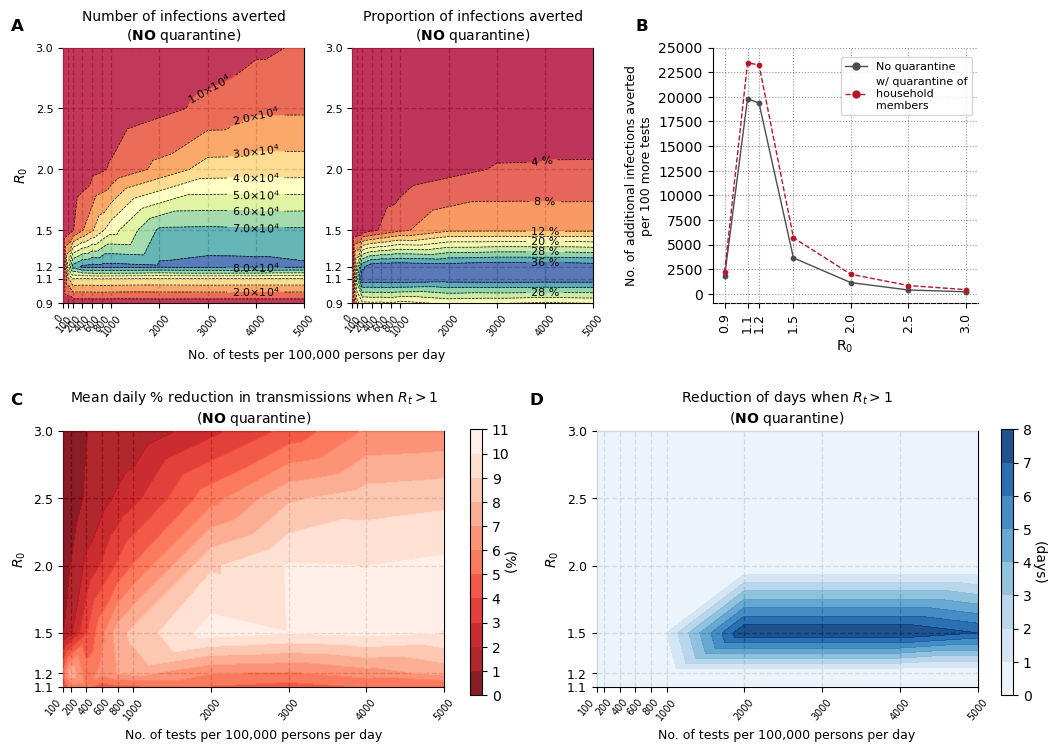

In [9]:
from scipy.stats.mstats import gmean 

qbool = 0 # quarantine bool 

def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}$\times 10^{{{e:d}}}$'.format(m=m, e=int(e))

with plt.style.context("default"): 
    fig = plt.figure(figsize=(11.8, 8.3))
    gs = GridSpec(nrows=2, ncols=1, hspace=0.5)
    
    sub_gs = gs[0].subgridspec(nrows=1, ncols=2, width_ratios=[2, 1], wspace=0.3)
    subsub_gs = sub_gs[0].subgridspec(nrows=1, ncols=2, wspace=0.2)
    ### first, we plot marginal benefit in absolute number of infections averted ### 
    ax = fig.add_subplot(subsub_gs[0])
    
    reg_symp_summary_df = symp_summary_df[pd.isna(symp_summary_df['init_immune_prop'])].copy()
    reg_zero_summary_df = zero_summary_df[pd.isna(zero_summary_df['init_immune_prop'])].copy()
    # filter data 
    quar_reg_symp_summary_df = reg_symp_summary_df[reg_symp_summary_df['quarantine_hcf_bool']==qbool]
    #display (quar_reg_symp_summary_df)
    N_tests_arr = np.sort(quar_reg_symp_summary_df['number_of_rdt_per_100k_per_day'].unique())
    R0_arr = np.sort(quar_reg_symp_summary_df['R0'].unique())

    plot_df = []
    for n, Ntests in enumerate(N_tests_arr): 
        mask_n = quar_reg_symp_summary_df['number_of_rdt_per_100k_per_day'] == Ntests
        for r, R0 in enumerate(R0_arr): 
            mask_r = quar_reg_symp_summary_df['R0'] == R0

            fdf = quar_reg_symp_summary_df[mask_n&mask_r]
            # get mean and sd values 
            try: 
                y_val = fdf['mean_n_sec_trans'].iloc[0]
            except: 
                print (Ntests, R0, 'missing')
                continue 

            # get zero baseline values 
            zero_fdf = reg_zero_summary_df[reg_zero_summary_df['R0']==R0]
            zero_y_val = zero_fdf['mean_n_sec_trans'].iloc[0]

            if n == 0: 
                plot_df.append({'NTests':0, 'R0':1.5 if R0 == 1.6 else R0, 
                                'y':abs(zero_y_val - zero_y_val),})

            # append to plot_df 
            plot_df.append({'NTests':Ntests, 'R0':1.5 if R0 == 1.6 else R0, 
                            'y':abs(y_val - zero_y_val),})
    plot_df = pd.DataFrame.from_dict(plot_df)
    
    x = plot_df['NTests'].to_numpy()
    y = plot_df['R0'].to_numpy()
    z = plot_df['y'].to_numpy()
    #print (min(z), max(z))
    vmin = 0.
    vmax = 9e4 
    contour_tick_fmt=lambda x: as_si(x,1)
    col_palette = 'Spectral'
    
    cntr1 = ax.tricontour(x, y, z, levels=np.linspace(vmin, vmax, 10), colors='k', linewidths=0.5, linestyles='--', zorder=100)
    ax.clabel(cntr1, levels=np.linspace(vmin, vmax, 10), inline=True, fontsize=8, fmt=contour_tick_fmt,
              manual=[(4000, 1.0), (4000, 1.2), (4000, 1.5), (4000, 1.7), (4000, 1.8), (4000, 2.0), (4000, 2.2), 
                      (4000, 2.5), (3000, 2.7)])
    cntr2 = ax.tricontourf(x, y, z, levels=np.linspace(vmin, vmax, 10), cmap=col_palette, alpha=0.9, zorder=50)

    ax.set_yticks(np.sort(np.unique(y)))
    ax.set_xticks(np.unique(x))
    ax.tick_params(axis='y', labelsize=8.)
    ax.tick_params(axis='x', rotation=0, labelsize=7.)
    ax.grid(axis='both', ls='--', lw=1., c='k', zorder=100)

    """cax = plt.axes(cbar_axes)
    cbar = fig.colorbar(cntr2, cax=cax, ticks=np.linspace(vmin, vmax, 11), format=cbar_format)
    cbar.set_label(cbar_title, rotation=270, labelpad=25.,)"""
    
    ax.set_ylabel(r'$R_0$', fontsize=10)

    # apply offset transform to all x ticklabels.
    for l, label in enumerate(ax.xaxis.get_majorticklabels()):
        if l == 0:
            dx = 3/72.; dy = 0/72. 
            offset = mpl.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
            label.set_transform(label.get_transform() - offset)
        elif l == 1:
            dx = 2.5/72.; dy = 0/72. 
            offset = mpl.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
            label.set_transform(label.get_transform() - offset)

    plt.setp(ax.get_xticklabels(), rotation=50, horizontalalignment='center')
    ax.set_title('Number of infections averted\n(' + r'$\bf{' + 'NO' + '}$ ' + 'quarantine)', fontsize=10)    
    ####### plot marginal benefit in proportion of infections averted ### 
    ax = fig.add_subplot(subsub_gs[1])
    
    plot_df = []
    for n, Ntests in enumerate(N_tests_arr): 
        mask_n = quar_reg_symp_summary_df['number_of_rdt_per_100k_per_day'] == Ntests
        for r, R0 in enumerate(R0_arr): 
            mask_r = quar_reg_symp_summary_df['R0'] == R0

            fdf = quar_reg_symp_summary_df[mask_n&mask_r]
            # get mean and sd values 
            try: 
                y_val = fdf['mean_n_sec_trans'].iloc[0]
            except: 
                print (Ntests, R0, 'missing')
                continue 

            # get zero baseline values 
            zero_fdf = reg_zero_summary_df[reg_zero_summary_df['R0']==R0]
            zero_y_val = zero_fdf['mean_n_sec_trans'].iloc[0]

            if n == 0: 
                plot_df.append({'NTests':0, 'R0':1.5 if R0 == 1.6 else R0, 
                                'y':100 * abs(zero_y_val - zero_y_val)/zero_y_val,})

            # append to plot_df 
            plot_df.append({'NTests':Ntests, 'R0':1.5 if R0 == 1.6 else R0, 
                            'y':100 * abs(y_val - zero_y_val)/zero_y_val,})
    plot_df = pd.DataFrame.from_dict(plot_df)
    
    x = plot_df['NTests'].to_numpy()
    y = plot_df['R0'].to_numpy()
    z = plot_df['y'].to_numpy()
    #print (min(z), max(z))
    vmin = 0.
    vmax = 40
    contour_tick_fmt=lambda x: "%.0f %%"%(x)
    col_palette = 'Spectral'
    
    cntr1 = ax.tricontour(x, y, z, levels=np.linspace(vmin, vmax, 11), colors='k', linewidths=0.5, linestyles='--', zorder=100)
    ax.clabel(cntr1, levels=np.linspace(vmin, vmax, 11), inline=True, fontsize=8, fmt=contour_tick_fmt,
              manual=[(4000, 1.0), (4000, 1.2), (4000, 1.3), (4000, 1.4), (4000, 1.5), (4000, 1.8), (4000, 2.0),])
    cntr2 = ax.tricontourf(x, y, z, levels=np.linspace(vmin, vmax, 11), cmap=col_palette, alpha=0.9, zorder=50)

    ax.set_yticks(np.sort(np.unique(y)))
    ax.set_xticks(np.unique(x))
    ax.tick_params(axis='y', labelsize=8.)
    ax.tick_params(axis='x', rotation=0, labelsize=7.)
    ax.grid(axis='both', ls='--', lw=1., c='k', zorder=100)

    """cax = plt.axes(cbar_axes)
    cbar = fig.colorbar(cntr2, cax=cax, ticks=np.linspace(vmin, vmax, 11), format=cbar_format)
    cbar.set_label(cbar_title, rotation=270, labelpad=25.,)"""
    
    fig.text(s='No. of tests per 100,000 persons per day', x=0.34, y=0.51, ha='center', va='center', fontsize=9,)    

    # apply offset transform to all x ticklabels.
    for l, label in enumerate(ax.xaxis.get_majorticklabels()):
        if l == 0:
            dx = 3/72.; dy = 0/72. 
            offset = mpl.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
            label.set_transform(label.get_transform() - offset)
        elif l == 1:
            dx = 2.5/72.; dy = 0/72. 
            offset = mpl.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
            label.set_transform(label.get_transform() - offset)

    plt.setp(ax.get_xticklabels(), rotation=50, horizontalalignment='center')
    ax.set_title('Proportion of infections averted\n(' + r'$\bf{' + 'NO' + '}$ ' + 'quarantine)', fontsize=10)
    
    ####### plot marginal benefit per 100 more tests 
    ax = fig.add_subplot(sub_gs[1])
    for q in np.arange(2): 
        fdf = symp_improvement_df[symp_improvement_df['quar_bool']==q]
        ax.plot(fdf['R0'], fdf['dydx'], ls='--' if q > 0 else '-', lw=1., color='#b2182b' if q > 0 else '#4d4d4d', zorder=100)
        ax.scatter(fdf['R0'], fdf['dydx'], s=10, color='#b2182b' if q > 0 else '#4d4d4d', zorder=100)
    ax.set_xlabel('R$_0$')
    for axis in ['top', 'right']: 
        ax.spines[axis].set_visible(False)
    ax.spines['bottom'].set_linestyle('--')
    ax.set_ylabel('No. of additional infections averted\nper 100 more tests',fontsize=9)
    ax.set_xticks(np.sort(np.unique(fdf['R0'])))
    ax.tick_params(axis='x', rotation=90, labelsize=9)
    #ax.axvspan(0.9, 1.2, facecolor='#542788', alpha=0.2, zorder=-200)    
    ax.grid(axis='both', ls='dotted', lw=0.8, c="#929292", alpha=1.)
    ax.set_yticks(np.linspace(0, 25000, 11))
    
    # fig legend 
    legend_elements = [Line2D([0], [0], marker='o', color='#4d4d4d', lw=1., ls='-', 
                               label="No quarantine", markersize=5),
                      Line2D([0], [0], marker='o', color='#b2182b', lw=1., ls='--', 
                               label="w/ quarantine of\nhousehold\nmembers", markersize=5)]
    ax.legend(handles=legend_elements, bbox_to_anchor=(1., 0.85), loc="center right", ncol=1, fontsize=8,)
    
    ##### finally we plot average amount of daily reduction 
    subgs2 = gs[1].subgridspec(nrows=1, ncols=2, wspace=0.4)
    
    ax = fig.add_subplot(subgs2[0])
    plot_df = []
    for r, R0 in enumerate(R0_arr): 
        mask_r = quar_reg_symp_summary_df['R0'] == R0
        zero_y_arr = np.array(reg_zero_summary_df[reg_zero_summary_df['R0']==R0]['mean_Reff_temp'].iloc[0])
        #print (gmean(zero_y_arr))
        x_arr = np.arange(len(zero_y_arr))
        # get earliest timepoint after which Rt < 1 
        masked_x_arr = x_arr[zero_y_arr < 1]
        end_i = -1
        for i in masked_x_arr: 
            if (zero_y_arr[i:] < 1).all() == True: 
                end_i = i
                break
        if end_i <= 0: 
            print (R0, "*")
            continue 
        else: 
            zero_gmean_R = gmean(zero_y_arr[:end_i])
            zero_R_below_1_day = end_i

        for n, Ntests in enumerate(N_tests_arr): 
            mask_n = quar_reg_symp_summary_df['number_of_rdt_per_100k_per_day'] == Ntests

            fdf = quar_reg_symp_summary_df[mask_n&mask_r]

            y_arr = np.array(fdf['mean_Reff_temp'].iloc[0])
            x_arr = np.arange(len(y_arr))

            # get earliest timepoint after which Rt < 1 
            masked_x_arr = x_arr[y_arr < 1]
            end_i = -1
            for i in masked_x_arr: 
                if (y_arr[i:] < 1).all() == True: 
                    end_i = i
                    break
            if end_i <= 0: 
                print (Ntests)
                continue 
            else: 
                gmean_R = gmean(y_arr[:end_i])
                R_below_1_day = end_i

                plot_df.append({"R0":1.5 if R0 == 1.6 else R0, "NTests":Ntests, 
                                "geo_R_red":(gmean(zero_y_arr[:end_i]) - gmean(y_arr[:end_i])), 
                                "R_below_1_diff":max([0, zero_R_below_1_day - R_below_1_day])})

    plot_df = pd.DataFrame.from_dict(plot_df)
    ### reduction in geometric R 
    x = plot_df['NTests'].to_numpy()
    y = plot_df['R0'].to_numpy()
    z = plot_df['geo_R_red'].to_numpy() * 100
    print (min(z), max(z))

    #cntr1 = ax.tricontour(x, y, z, levels=[2,4,6,8,10], colors='k', linewidths=0.5, linestyles='--', zorder=100)
    #ax.clabel(cntr1, levels=[2,4,6,8,10], inline=True, fontsize=9, fmt=lambda x:"%.0f"%(x),)
    cntr2 = ax.tricontourf(x, y, z, levels=np.linspace(0, 11, 12), cmap='Reds_r', alpha=0.9, zorder=50)

    ax.set_yticks(np.sort(np.unique(y)))
    ax.set_xticks(np.unique(x))
    ax.tick_params(axis='y', labelsize=9.)
    ax.tick_params(axis='x', rotation=0, labelsize=7.)
    ax.grid(axis='both', ls='--', lw=1., c='k', zorder=100)
    ax.set_ylabel('$R_0$', fontsize=10)

    plt.setp(ax.get_xticklabels()[0], rotation=50, horizontalalignment='right')
    plt.setp(ax.get_xticklabels()[1:], rotation=50, horizontalalignment='center')
    
    ax.set_title('Mean daily % reduction in transmissions when $R_t > 1$\n(' + r'$\bf{' + 'NO' + '}$ ' + 'quarantine)', 
                 fontsize=10)
    ax.set_xlabel('No. of tests per 100,000 persons per day', ha='center', va='center', fontsize=9, labelpad=10) 
    
    # color bar 
    cax = plt.axes([0.47, 0.1, 0.01, 0.32])
    cbar = fig.colorbar(cntr2, cax=cax, ticks=np.linspace(0,11,12), format=None)
    cbar.set_label("(%)", rotation=270,)

    ### change in day before R drops below 1 
    ax = fig.add_subplot(subgs2[1])
    z = plot_df['R_below_1_diff'].to_numpy()
    print (min(z), max(z))
    #cntr1 = ax.tricontour(x, y, z, levels=np.linspace(-2, 20, 11), colors='k', linewidths=0.5, linestyles='--', zorder=100)
    #ax.clabel(cntr1, levels=np.linspace(-2, 20, 6), inline=True, fontsize=8)# fmt=contour_tick_fmt,)
    #manual=contour_tick_loc1 if quarantine_bool > 0 else contour_tick_loc0)
    cntr2 = ax.tricontourf(x, y, z, levels=np.linspace(0, 8, 9), cmap='Blues', alpha=0.9, zorder=50)

    ax.set_yticks(np.sort(np.unique(y)))
    ax.set_xticks(np.unique(x))
    ax.tick_params(axis='y', labelsize=9.)
    ax.tick_params(axis='x', rotation=0, labelsize=7.)
    ax.grid(axis='both', ls='--', lw=1., c='k', zorder=100)

    ax.set_ylabel('$R_0$', fontsize=10)
    
    plt.setp(ax.get_xticklabels()[0], rotation=50, horizontalalignment='right')
    plt.setp(ax.get_xticklabels()[1:], rotation=50, horizontalalignment='center')
    
    ax.set_title('Reduction of days when $R_t > 1$\n(' + r'$\bf{' + 'NO' + '}$ ' + 'quarantine)', 
                 fontsize=10)
    ax.set_xlabel('No. of tests per 100,000 persons per day', ha='center', va='center', fontsize=9, labelpad=10) 
    
    # color bar 
    cax = plt.axes([0.92, 0.1, 0.01, 0.32])
    cbar = fig.colorbar(cntr2, cax=cax, ticks=np.linspace(0,11,12), format=None)
    cbar.set_label("(days)", rotation=270, labelpad=10)
    
    # annotation 
    fig.text(s=r"$\bf{A}$", x=0.08, y=.9, fontsize=12)
    fig.text(s=r"$\bf{B}$", x=0.61, y=.9, fontsize=12)
    fig.text(s=r"$\bf{C}$", x=0.08, y=.45, fontsize=12)
    fig.text(s=r"$\bf{D}$", x=0.52, y=.45, fontsize=12)
    
    plt.savefig('./manuscript/Figure5.png', dpi=330, bbox_inches='tight')
    plt.show()

0.9 *
0.5699652026665225 14.99671057541403


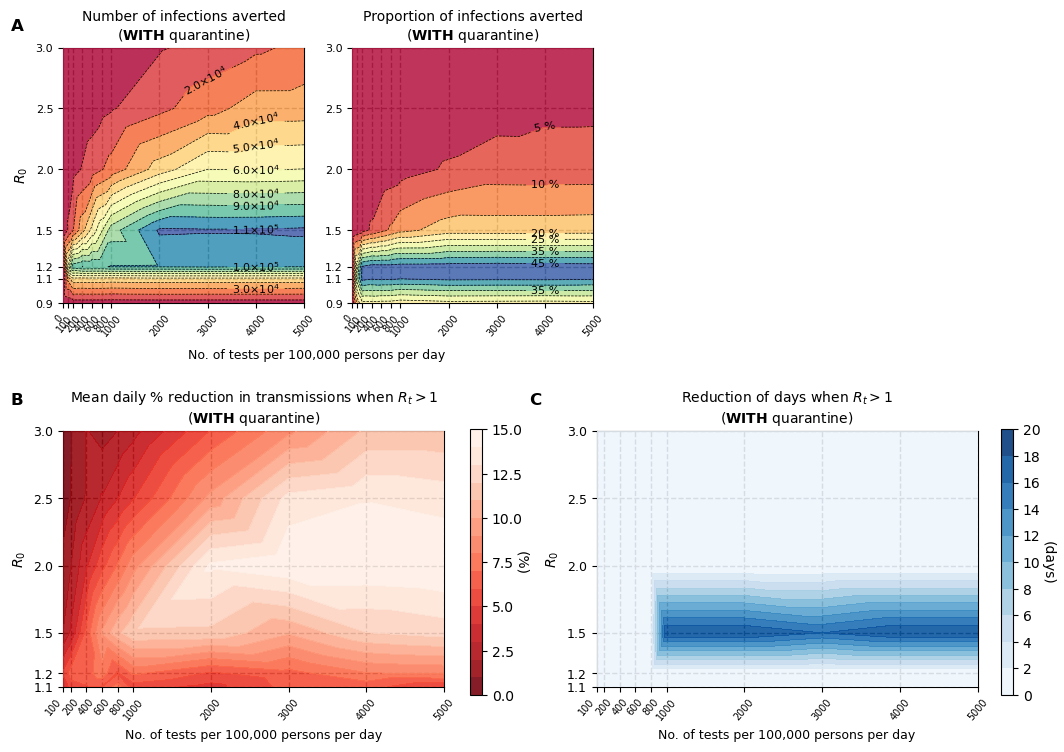

In [10]:
from scipy.stats.mstats import gmean 

qbool = 1 # quarantine bool 

with plt.style.context("default"): 
    fig = plt.figure(figsize=(11.8, 8.3))
    gs = GridSpec(nrows=2, ncols=1, hspace=0.5)
    
    sub_gs = gs[0].subgridspec(nrows=1, ncols=2, width_ratios=[2, 1], wspace=0.3)
    subsub_gs = sub_gs[0].subgridspec(nrows=1, ncols=2, wspace=0.2)
    ### first, we plot marginal benefit in absolute number of infections averted ### 
    ax = fig.add_subplot(subsub_gs[0])
    
    reg_symp_summary_df = symp_summary_df[pd.isna(symp_summary_df['init_immune_prop'])].copy()
    reg_zero_summary_df = zero_summary_df[pd.isna(zero_summary_df['init_immune_prop'])].copy()
    # filter data 
    quar_reg_symp_summary_df = reg_symp_summary_df[reg_symp_summary_df['quarantine_hcf_bool']==qbool]
    #display (quar_reg_symp_summary_df)
    N_tests_arr = np.sort(quar_reg_symp_summary_df['number_of_rdt_per_100k_per_day'].unique())
    R0_arr = np.sort(quar_reg_symp_summary_df['R0'].unique())

    plot_df = []
    for n, Ntests in enumerate(N_tests_arr): 
        mask_n = quar_reg_symp_summary_df['number_of_rdt_per_100k_per_day'] == Ntests
        for r, R0 in enumerate(R0_arr): 
            mask_r = quar_reg_symp_summary_df['R0'] == R0

            fdf = quar_reg_symp_summary_df[mask_n&mask_r]
            # get mean and sd values 
            try: 
                y_val = fdf['mean_n_sec_trans'].iloc[0]
            except: 
                print (Ntests, R0, 'missing')
                continue 

            # get zero baseline values 
            zero_fdf = reg_zero_summary_df[reg_zero_summary_df['R0']==R0]
            zero_y_val = zero_fdf['mean_n_sec_trans'].iloc[0]

            if n == 0: 
                plot_df.append({'NTests':0, 'R0':1.5 if R0 == 1.6 else R0, 
                                'y':abs(zero_y_val - zero_y_val),})

            # append to plot_df 
            plot_df.append({'NTests':Ntests, 'R0':1.5 if R0 == 1.6 else R0, 
                            'y':abs(y_val - zero_y_val),})
    plot_df = pd.DataFrame.from_dict(plot_df)
    
    x = plot_df['NTests'].to_numpy()
    y = plot_df['R0'].to_numpy()
    z = plot_df['y'].to_numpy()
    #print (min(z), max(z))
    vmin = 0.
    vmax = 12e4 
    contour_tick_fmt=lambda x: as_si(x,1)
    col_palette = 'Spectral'
    
    cntr1 = ax.tricontour(x, y, z, levels=np.linspace(vmin, vmax, 13), colors='k', linewidths=0.5, linestyles='--', zorder=100)
    ax.clabel(cntr1, levels=np.linspace(vmin, vmax, 13), inline=True, fontsize=8, fmt=contour_tick_fmt,
              manual=[(4000, 1.0), (4000, 1.2), (4000, 1.5), (4000, 1.7), (4000, 1.8), (4000, 2.0), (4000, 2.2), 
                      (4000, 2.5), (3000, 2.7)])
    cntr2 = ax.tricontourf(x, y, z, levels=np.linspace(vmin, vmax, 13), cmap=col_palette, alpha=0.9, zorder=50)

    ax.set_yticks(np.sort(np.unique(y)))
    ax.set_xticks(np.unique(x))
    ax.tick_params(axis='y', labelsize=8.)
    ax.tick_params(axis='x', rotation=0, labelsize=7.)
    ax.grid(axis='both', ls='--', lw=1., c='k', zorder=100)

    """cax = plt.axes(cbar_axes)
    cbar = fig.colorbar(cntr2, cax=cax, ticks=np.linspace(vmin, vmax, 11), format=cbar_format)
    cbar.set_label(cbar_title, rotation=270, labelpad=25.,)"""
    
    ax.set_ylabel(r'$R_0$', fontsize=10)

    # apply offset transform to all x ticklabels.
    for l, label in enumerate(ax.xaxis.get_majorticklabels()):
        if l == 0:
            dx = 3/72.; dy = 0/72. 
            offset = mpl.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
            label.set_transform(label.get_transform() - offset)
        elif l == 1:
            dx = 2.5/72.; dy = 0/72. 
            offset = mpl.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
            label.set_transform(label.get_transform() - offset)

    plt.setp(ax.get_xticklabels(), rotation=50, horizontalalignment='center')
    ax.set_title('Number of infections averted\n(' + r'$\bf{' + 'WITH' + '}$ ' + 'quarantine)', fontsize=10)    
    ####### plot marginal benefit in proportion of infections averted ### 
    ax = fig.add_subplot(subsub_gs[1])
    
    plot_df = []
    for n, Ntests in enumerate(N_tests_arr): 
        mask_n = quar_reg_symp_summary_df['number_of_rdt_per_100k_per_day'] == Ntests
        for r, R0 in enumerate(R0_arr): 
            mask_r = quar_reg_symp_summary_df['R0'] == R0

            fdf = quar_reg_symp_summary_df[mask_n&mask_r]
            # get mean and sd values 
            try: 
                y_val = fdf['mean_n_sec_trans'].iloc[0]
            except: 
                print (Ntests, R0, 'missing')
                continue 

            # get zero baseline values 
            zero_fdf = reg_zero_summary_df[reg_zero_summary_df['R0']==R0]
            zero_y_val = zero_fdf['mean_n_sec_trans'].iloc[0]

            if n == 0: 
                plot_df.append({'NTests':0, 'R0':1.5 if R0 == 1.6 else R0, 
                                'y':100 * abs(zero_y_val - zero_y_val)/zero_y_val,})

            # append to plot_df 
            plot_df.append({'NTests':Ntests, 'R0':1.5 if R0 == 1.6 else R0, 
                            'y':100 * abs(y_val - zero_y_val)/zero_y_val,})
    plot_df = pd.DataFrame.from_dict(plot_df)
    
    x = plot_df['NTests'].to_numpy()
    y = plot_df['R0'].to_numpy()
    z = plot_df['y'].to_numpy()
    #print (min(z), max(z))
    vmin = 0.
    vmax = 50
    contour_tick_fmt=lambda x: "%.0f %%"%(x)
    col_palette = 'Spectral'
    
    cntr1 = ax.tricontour(x, y, z, levels=np.linspace(vmin, vmax, 11), colors='k', linewidths=0.5, linestyles='--', zorder=100)
    ax.clabel(cntr1, levels=np.linspace(vmin, vmax, 11), inline=True, fontsize=8, fmt=contour_tick_fmt,
              manual=[(4000, 1.0), (4000, 1.2), (4000, 1.3), (4000, 1.4), (4000, 1.5), (4000, 1.8), (4000, 2.5),])
    cntr2 = ax.tricontourf(x, y, z, levels=np.linspace(vmin, vmax, 11), cmap=col_palette, alpha=0.9, zorder=50)

    ax.set_yticks(np.sort(np.unique(y)))
    ax.set_xticks(np.unique(x))
    ax.tick_params(axis='y', labelsize=8.)
    ax.tick_params(axis='x', rotation=0, labelsize=7.)
    ax.grid(axis='both', ls='--', lw=1., c='k', zorder=100)

    """cax = plt.axes(cbar_axes)
    cbar = fig.colorbar(cntr2, cax=cax, ticks=np.linspace(vmin, vmax, 11), format=cbar_format)
    cbar.set_label(cbar_title, rotation=270, labelpad=25.,)"""
    
    fig.text(s='No. of tests per 100,000 persons per day', x=0.34, y=0.51, ha='center', va='center', fontsize=9,)    

    # apply offset transform to all x ticklabels.
    for l, label in enumerate(ax.xaxis.get_majorticklabels()):
        if l == 0:
            dx = 3/72.; dy = 0/72. 
            offset = mpl.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
            label.set_transform(label.get_transform() - offset)
        elif l == 1:
            dx = 2.5/72.; dy = 0/72. 
            offset = mpl.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
            label.set_transform(label.get_transform() - offset)

    plt.setp(ax.get_xticklabels(), rotation=50, horizontalalignment='center')
    ax.set_title('Proportion of infections averted\n(' + r'$\bf{' + 'WITH' + '}$ ' + 'quarantine)', fontsize=10)
    
    ##### finally we plot average amount of daily reduction 
    subgs2 = gs[1].subgridspec(nrows=1, ncols=2, wspace=0.4)
    
    ax = fig.add_subplot(subgs2[0])
    plot_df = []
    for r, R0 in enumerate(R0_arr): 
        mask_r = quar_reg_symp_summary_df['R0'] == R0
        zero_y_arr = np.array(reg_zero_summary_df[reg_zero_summary_df['R0']==R0]['mean_Reff_temp'].iloc[0])
        #print (gmean(zero_y_arr))
        x_arr = np.arange(len(zero_y_arr))
        # get earliest timepoint after which Rt < 1 
        masked_x_arr = x_arr[zero_y_arr < 1]
        end_i = -1
        for i in masked_x_arr: 
            if (zero_y_arr[i:] < 1).all() == True: 
                end_i = i
                break
        if end_i <= 0: 
            print (R0, "*")
            continue 
        else: 
            zero_gmean_R = gmean(zero_y_arr[:end_i])
            zero_R_below_1_day = end_i

        for n, Ntests in enumerate(N_tests_arr): 
            mask_n = quar_reg_symp_summary_df['number_of_rdt_per_100k_per_day'] == Ntests

            fdf = quar_reg_symp_summary_df[mask_n&mask_r]

            y_arr = np.array(fdf['mean_Reff_temp'].iloc[0])
            x_arr = np.arange(len(y_arr))

            # get earliest timepoint after which Rt < 1 
            masked_x_arr = x_arr[y_arr < 1]
            end_i = -1
            for i in masked_x_arr: 
                if (y_arr[i:] < 1).all() == True: 
                    end_i = i
                    break
            if end_i <= 0: 
                print (Ntests)
                continue 
            else: 
                gmean_R = gmean(y_arr[:end_i])
                R_below_1_day = end_i

                plot_df.append({"R0":1.5 if R0 == 1.6 else R0, "NTests":Ntests, 
                                "geo_R_red":(gmean(zero_y_arr[:end_i]) - gmean(y_arr[:end_i])), 
                                "R_below_1_diff":max([0, zero_R_below_1_day - R_below_1_day])})

    plot_df = pd.DataFrame.from_dict(plot_df)
    ### reduction in geometric R 
    x = plot_df['NTests'].to_numpy()
    y = plot_df['R0'].to_numpy()
    z = plot_df['geo_R_red'].to_numpy() * 100
    print (min(z), max(z))

    #cntr1 = ax.tricontour(x, y, z, levels=[2,4,6,8,10], colors='k', linewidths=0.5, linestyles='--', zorder=100)
    #ax.clabel(cntr1, levels=[2,4,6,8,10], inline=True, fontsize=9, fmt=lambda x:"%.0f"%(x),)
    cntr2 = ax.tricontourf(x, y, z, levels=np.linspace(0, 15, 16), cmap='Reds_r', alpha=0.9, zorder=50)

    ax.set_yticks(np.sort(np.unique(y)))
    ax.set_xticks(np.unique(x))
    ax.tick_params(axis='y', labelsize=9.)
    ax.tick_params(axis='x', rotation=0, labelsize=7.)
    ax.grid(axis='both', ls='--', lw=1., c='k', zorder=100)
    ax.set_ylabel('$R_0$', fontsize=10)

    plt.setp(ax.get_xticklabels()[0], rotation=50, horizontalalignment='right')
    plt.setp(ax.get_xticklabels()[1:], rotation=50, horizontalalignment='center')
    
    ax.set_title('Mean daily % reduction in transmissions when $R_t > 1$\n(' + r'$\bf{' + 'WITH' + '}$ ' + 'quarantine)', 
                 fontsize=10)
    ax.set_xlabel('No. of tests per 100,000 persons per day', ha='center', va='center', fontsize=9, labelpad=10) 
    
    # color bar 
    cax = plt.axes([0.47, 0.1, 0.01, 0.32])
    cbar = fig.colorbar(cntr2, cax=cax, ticks=np.linspace(0,15,7), format=None)
    cbar.set_label("(%)", rotation=270,)

    ### change in day before R drops below 1 
    ax = fig.add_subplot(subgs2[1])
    z = plot_df['R_below_1_diff'].to_numpy()
    #print (min(z), max(z))
    #cntr1 = ax.tricontour(x, y, z, levels=np.linspace(-2, 20, 11), colors='k', linewidths=0.5, linestyles='--', zorder=100)
    #ax.clabel(cntr1, levels=np.linspace(-2, 20, 6), inline=True, fontsize=8)# fmt=contour_tick_fmt,)
    #manual=contour_tick_loc1 if quarantine_bool > 0 else contour_tick_loc0)
    cntr2 = ax.tricontourf(x, y, z, levels=np.linspace(0, 20, 11), cmap='Blues', alpha=0.9, zorder=50)

    ax.set_yticks(np.sort(np.unique(y)))
    ax.set_xticks(np.unique(x))
    ax.tick_params(axis='y', labelsize=9.)
    ax.tick_params(axis='x', rotation=0, labelsize=7.)
    ax.grid(axis='both', ls='--', lw=1., c='k', zorder=100)

    ax.set_ylabel('$R_0$', fontsize=10)
    
    plt.setp(ax.get_xticklabels()[0], rotation=50, horizontalalignment='right')
    plt.setp(ax.get_xticklabels()[1:], rotation=50, horizontalalignment='center')
    
    ax.set_title('Reduction of days when $R_t > 1$\n(' + r'$\bf{' + 'WITH' + '}$ ' + 'quarantine)', 
                 fontsize=10)
    ax.set_xlabel('No. of tests per 100,000 persons per day', ha='center', va='center', fontsize=9, labelpad=10) 
    
    # color bar 
    cax = plt.axes([0.92, 0.1, 0.01, 0.32])
    cbar = fig.colorbar(cntr2, cax=cax, ticks=np.linspace(0,20,11), format=None)
    cbar.set_label("(days)", rotation=270, labelpad=10)
    
    # annotation 
    fig.text(s=r"$\bf{A}$", x=0.08, y=.9, fontsize=12)
    fig.text(s=r"$\bf{B}$", x=0.08, y=.45, fontsize=12)
    fig.text(s=r"$\bf{C}$", x=0.52, y=.45, fontsize=12)
    
    plt.savefig('./manuscript/SFigure3.png', dpi=330, bbox_inches='tight')
    plt.show()

## Symptomatic-first community testing 

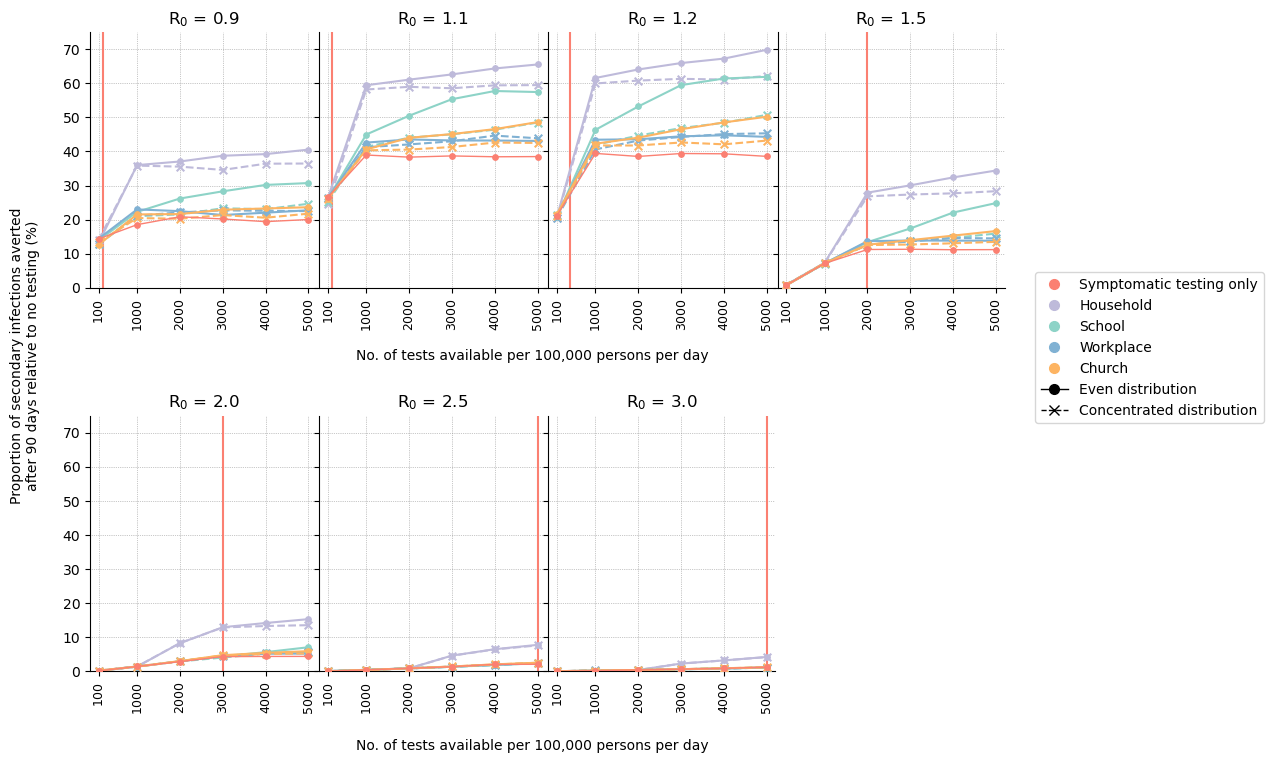

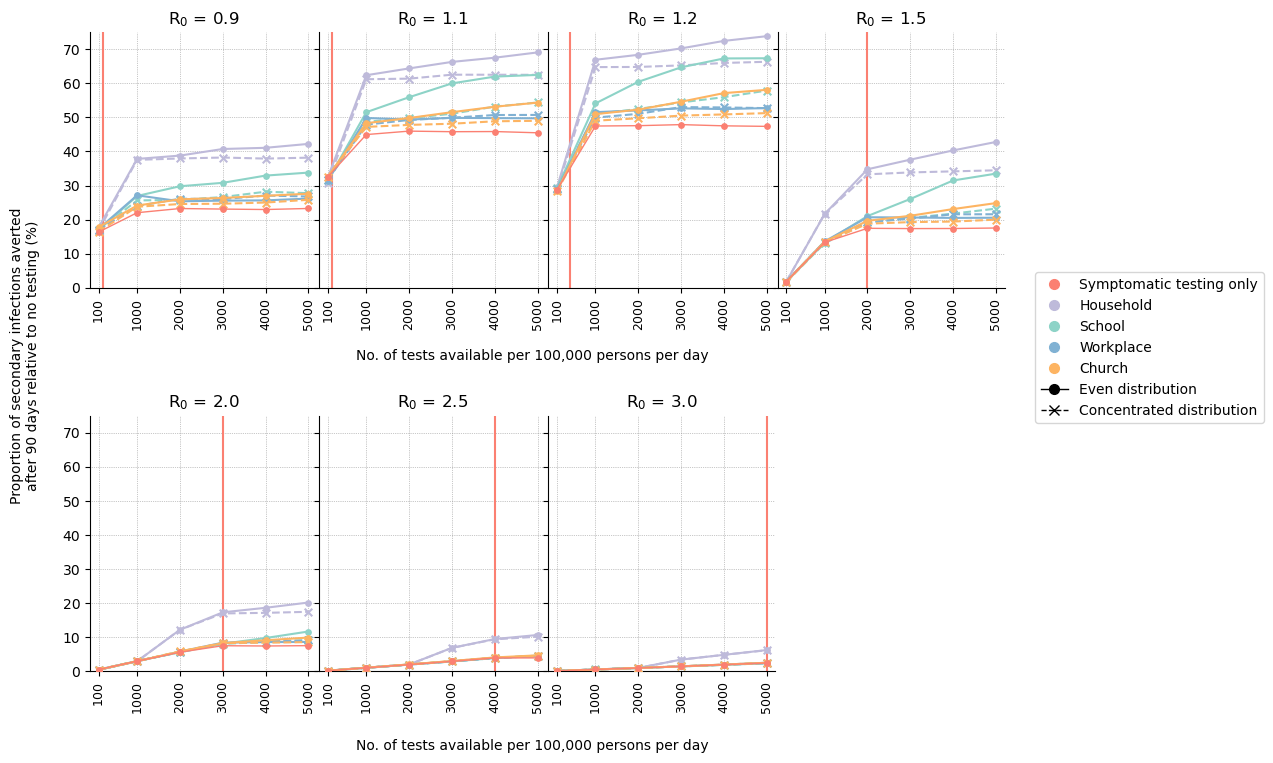

In [41]:
setting_cmap = {setting:sns.color_palette("Set3", 6)[s] for s, setting in enumerate(['school', '', 'household', 'baseline', 'workplace', 'church'])}

with plt.style.context("default"): 
    
    for q in np.arange(2): 

        fig = plt.figure(figsize=(11.8, 8.3))
        gs = GridSpec(nrows=2, ncols=4, hspace=0.5, wspace=0.01)
        
        q_symp_improvement_df = symp_improvement_df[symp_improvement_df['quar_bool']==q]
        
        for r, R0 in enumerate(np.sort(comm_summary_df['R0'].unique())): 
            
            if R0 == 1.6: 
                R0_q_symp_improvement_df = q_symp_improvement_df[q_symp_improvement_df['R0']==1.5]
            else: 
                R0_q_symp_improvement_df = q_symp_improvement_df[q_symp_improvement_df['R0']==R0]
            
            axI, axJ = int(r/4), (r%4)
            ax = fig.add_subplot(gs[axI, axJ])
            ax.set_title('R$_0$ = %.1f'%(1.5 if R0 ==1.6 else R0))

            R0_comm_summary_df = comm_summary_df[pd.isna(comm_summary_df['check'])&(comm_summary_df['R0'] == R0)&(comm_summary_df['quarantine_hcf_bool']==q)&(pd.isna(comm_summary_df['init_immune_prop']))].sort_values(by="number_of_rdt_per_100k_per_day")
            R0_symp_summary_df = symp_summary_df[(symp_summary_df['R0'] == R0)&(symp_summary_df['quarantine_hcf_bool']==q)&(pd.isna(symp_summary_df['init_immune_prop']))].sort_values(by="number_of_rdt_per_100k_per_day")
            
            R0_zero_summary_df = zero_summary_df[(zero_summary_df['R0'] == R0)&(pd.isna(zero_summary_df['init_immune_prop']))]
            # no testing baseline 
            zero_y = R0_zero_summary_df['mean_n_sec_trans'].iloc[0]
            
            # plot symptomatic result 
            symp_x_arr = R0_symp_summary_df['number_of_rdt_per_100k_per_day'].to_numpy()
            symp_y_arr = (zero_y - R0_symp_summary_df['mean_n_sec_trans'].to_numpy())/zero_y
            
            symp_mask = (symp_x_arr<=100)|(symp_x_arr>=1000)
            symp_x_arr = symp_x_arr[symp_mask]
            symp_y_arr = symp_y_arr[symp_mask]
            
            ax.plot(symp_x_arr, 100 * symp_y_arr, ls='-', lw=1., color=setting_cmap['baseline'], zorder=100)
            ax.scatter(symp_x_arr, 100 * symp_y_arr, marker='o', s=15, color=setting_cmap['baseline'], zorder=100)
            
            ax.axvline(R0_q_symp_improvement_df['N_enough'].iloc[0], color=setting_cmap['baseline'],)
            
            # plot comm result 
            for setting in ['household', 'school', 'workplace', 'church']: 
                setting_R0_comm_summary_df = R0_comm_summary_df[R0_comm_summary_df['setting']==setting]
                if len(setting_R0_comm_summary_df) == 0: 
                    continue 
                
                for d, density in enumerate(['low', 'high_fixed']):
                    fdf = setting_R0_comm_summary_df[setting_R0_comm_summary_df["density"]==density]
                    
                    comm_x_arr = fdf['number_of_rdt_per_100k_per_day'].to_numpy()
                    comm_mask = (comm_x_arr<=100)|(comm_x_arr>=1000)
                    
                    comm_y_arr = fdf['mean_n_sec_trans'].to_numpy()[comm_mask]
                    comm_y_sd_arr = fdf['sd_n_sec_trans'].to_numpy()[comm_mask]
                    comm_x_arr = comm_x_arr[comm_mask]
                    
                    plot_y_arr = (zero_y - comm_y_arr)/zero_y
                    
                    ax.plot(comm_x_arr, 100 * plot_y_arr, ls='--' if d > 0 else '-', color=setting_cmap[setting], zorder=50, lw=1.5,)
                    ax.scatter(comm_x_arr, 100 * plot_y_arr, marker='x' if d > 0 else 'o', s=30 if d > 0 else 15, color=setting_cmap[setting], zorder=50)
            
            ax.set_ylim(0., 75)
            
            ax.set_xticks([100, 1000, 2000, 3000, 4000, 5000])
            ax.set_xlim(-100, 5200)
            ax.grid(axis='both', ls='dotted', lw=0.5, c='#929292', zorder=-100)
            ax.tick_params(axis='x', rotation=90, labelsize=9)
            
            if axJ != 0: 
                ax.set_yticklabels([])
            for axis in ['top', 'right']: 
                ax.spines[axis].set_visible(False)
                
        fig.text(s='No. of tests available per 100,000 persons per day', x=0.5, y=0.02, ha='center', va='center', fontsize=10)
        fig.text(s='No. of tests available per 100,000 persons per day', x=0.5, y=0.49, ha='center', va='center', fontsize=10)  
        fig.text(s='Proportion of secondary infections averted\nafter 90 days relative to no testing (%)', x=0.07, y=0.49, ha='center', va='center', rotation=90, fontsize=10)          
        
        # legend 
        legend_elements = []
        for s, setting in zip(['baseline', 'household', 'school', 'workplace', 'church'], ['Symptomatic testing only', 'Household', 'School', 'Workplace', 'Church']):
            legend_elements.append(Line2D([0], [0], marker='o', color=setting_cmap[s], lw=0., label=setting, 
                                          markerfacecolor=setting_cmap[s], markersize=7))
        legend_elements.append(Line2D([0], [0], marker='o', color='k', lw=1., ls='-', label='Even distribution', 
                                          markerfacecolor='k', markersize=7))
        legend_elements.append(Line2D([0], [0], marker='x', color='k', lw=1., ls='--', label='Concentrated distribution', 
                                          markerfacecolor='k', markersize=7))
        legend = fig.legend(handles=legend_elements, bbox_to_anchor=(.92, 0.5), loc="center left", ncol=1, fontsize=10,)
        
        #plt.savefig('./figures/comm_screen_pc_inf_averted_q%i.png'%(q), bbox_inches="tight", dpi=330)
        if q > 0: 
            plt.savefig('./manuscript/Figure6.png', dpi=330, bbox_inches="tight")
        else: 
            plt.savefig('./manuscript/SFigure4.png', dpi=330, bbox_inches="tight")
        #plt.savefig('./figures/comm_screen_pc_inf_averted_q%i.pdf'%(q), bbox_inches="tight")
        plt.show()

## Households are key transmission sources

In [12]:
def plot_6a(ax):
    values = [zero_summary_df[zero_summary_df['R0']==2.5]['mean_n_sec_trans_%s'%(setting)].iloc[0] for setting in ['household', 'school', 'workplace_formal', 'workplace_informal', 'church', 'community']]
    values = [100 * v/sum(values) for v in values]
    # Number of variables we're plotting.
    num_vars = len(values)
    # Split the circle into even parts and save the angles
    # so we know where to put each axis.
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    # The plot is a circle, so we need to "complete the loop"
    # and append the start value to the end.
    values += values[:1]
    angles += angles[:1]
    # Draw the outline of our data.
    ax.plot(angles, values, color='#d73027', linewidth=1)
    ax.fill(angles, values, color='#d73027', alpha=0.4)

    # Fix axis to go in the right order and start at 12 o'clock.
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw axis lines for each angle and label.
    ax.set_thetagrids(np.degrees(angles[:-1]), ['Household', 'School', 'Workplace (formal)', 'Workplace (informal)', 'Church', 'Community'], 
                      fontsize=9)
    # Go through labels and adjust alignment based on where
    # it is in the circle.
    for label, angle in zip(ax.get_xticklabels(), angles):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')
    
    # set ylim 
    curr_max_val = 60
    ax.set_ylim(0, curr_max_val)
    ax.set_rgrids(np.linspace(0, curr_max_val, 7))
    ax.tick_params(axis='y', labelsize=8)
    ax.set_yticklabels(['%i%%'%(i) for i in ax.get_yticks()])
    return 

In [13]:
def plot_6b(gs): 
    setting_cmap = {setting:sns.color_palette("Set3", 6)[s] for s, setting in enumerate(['school', '', 'household', 'baseline', 'workplace', 'church'])}

    cm1 = comm_summary_df['quarantine_hcf_bool'] == 0
    sm1 = reg_symp_summary_df['quarantine_hcf_bool'] == 0
    
    cm3 = comm_summary_df['R0'] == 1.6
    sm3 = reg_symp_summary_df['R0'] == 1.6
    zm1 = zero_summary_df['R0'] == 1.6
    
    cm2 = comm_summary_df['number_of_rdt_per_100k_per_day'] == 5000
    sm2 = reg_symp_summary_df['number_of_rdt_per_100k_per_day'] == 5000
    
    cm5 = comm_summary_df['density'] == 'low'
        
    ax0 = fig.add_subplot(gs[0])
    ax1 = fig.add_subplot(gs[1])
    ax2 = fig.add_subplot(gs[2])   

    for s, test_setting in enumerate(['church', 'household',]):
        cm4 = comm_summary_df['setting'] == test_setting

        symp_fdf = reg_symp_summary_df[sm1&sm2&sm3] 
        comm_fdf = comm_summary_df[cm1&cm2&cm3&cm4&cm5]
        zero_fdf = zero_summary_df[zm1]                     

        if len(comm_fdf) == 0: 
            continue 

        # plot mean number of reported infections from all testing 
        symp_total_dia_inf_persons = np.array(symp_fdf['mean_reported_infections_stats'].iloc[0])[:,4] + np.array(symp_fdf['mean_reported_infections_stats'].iloc[0])[:,6:9].sum(axis=1)
        ax0.plot(symp_total_dia_inf_persons, ls='--', color=setting_cmap['baseline'])

        comm_total_dia_inf_persons = np.array(comm_fdf['mean_reported_infections_stats'].iloc[0])[:,4] +  np.array(comm_fdf['mean_reported_infections_stats'].iloc[0])[:,6:9].sum(axis=1)
        ax0.plot(comm_total_dia_inf_persons, color=setting_cmap[test_setting])

        # plot mean overall Rt 
        ax1.plot(np.arange(2,91), np.array(symp_fdf['mean_Reff_temp'].iloc[0])[2:], ls='--', c=setting_cmap['baseline'])
        ax1.plot(np.arange(2,91), np.array(comm_fdf['mean_Reff_temp'].iloc[0])[2:], c=setting_cmap[test_setting],)

        # plot cummulative reduction in infections over time 
        zero_cumm_inf = 1e6 - np.array(zero_fdf['mean_Sus_temp'].iloc[0])
        symp_cumm_inf = 1e6 - np.array(symp_fdf['mean_Sus_temp'].iloc[0])
        comm_cumm_inf = 1e6 - np.array(comm_fdf['mean_Sus_temp'].iloc[0])
        #ax2.plot(zero_cumm_inf, ls='dotted', c='k')
        
        symp_arr = np.array(abs(zero_cumm_inf-symp_cumm_inf))
        comm_arr = np.array(abs(zero_cumm_inf-comm_cumm_inf))
        
        #print (comm_arr)
        
        ax2.plot(symp_arr, ls='--', c=setting_cmap['baseline'])
        ax2.plot(comm_arr, ls='-', c=setting_cmap[test_setting])

    for a, ax in enumerate([ax0, ax1, ax2]): 
        ax.set_xlim(0,91)
        for axis in ['top', 'right']: 
            ax.spines[axis].set_visible(False)
        ax.set_xlabel('Time (days)', fontsize=8)
        if a == 1: 
            ax.set_ylim(0, 3.)
            ax.set_ylabel('$R_{t}$', fontsize=8)
        elif a == 0: 
            ax.set_ylim(0, 20000)
            ax.set_ylabel('Mean number of diagnosed cases', fontsize=8)
            ax.ticklabel_format(axis="y", style="sci", useMathText=True, scilimits=(0,0))
        else: 
            ax.set_ylabel('No. of infections averted', fontsize=8)
            ax.ticklabel_format(axis="y", style="sci", useMathText=True, scilimits=(0,0))
        ax.tick_params(axis='both', labelsize=7)

    # legend 
    legend_elements = []
    for s, setting in zip(['baseline', 'household', 'church'], ['Symptomatic\ntesting only', 'Household', 'Church']):
        legend_elements.append(Line2D([0], [0], marker='o', color=setting_cmap[s], lw=0., label=setting, 
                                      markerfacecolor=setting_cmap[s], markersize=5))
    legend = ax0.legend(handles=legend_elements, bbox_to_anchor=(1., 1.), loc="upper right", ncol=1, fontsize=7,)

In [33]:
import itertools 

def plot6c(gs):

    setting_arr = ['overseas', 'household', 'school', 'school_class', 'workplace_formal', 'workplace_informal', 'community', 'church', 'bars']
    spillover_settings = setting_arr[1:8]

    rmask = zero_summary_df['R0']==1.6

    fdf = zero_summary_df[rmask]

    full_setting_arr = ['household', 'school', 'workplace_formal', 'workplace_informal', 'church', 'community']

    ### 
    spillover_df = []
    total_export_df = {}
    for i, j in itertools.permutations(np.arange(7), 2):
        if spillover_settings[i] == 'school_class' or spillover_settings[j] == 'school_class': 
            continue 
        n_trans_setting = fdf['mean_n_sec_trans_%s'%(spillover_settings[j])].iloc[0]
        spillover_df.append({'from':spillover_settings[i], 'to':spillover_settings[j], 
                             'y':fdf['mean_spillover_%s_%s'%(spillover_settings[i], spillover_settings[j])].iloc[0]/n_trans_setting})

        try: 
            total_export_df[spillover_settings[i]] += fdf['mean_spillover_%s_%s'%(spillover_settings[i], spillover_settings[j])].iloc[0]
        except: 
            total_export_df[spillover_settings[i]] = fdf['mean_spillover_%s_%s'%(spillover_settings[i], spillover_settings[j])].iloc[0]

    spillover_df = pd.DataFrame.from_dict(spillover_df)
    
    append_df = []
    for setting in full_setting_arr: 
        y = spillover_df[spillover_df['to']==setting]['y'].sum()
        append_df.append({'from':setting, 'to':setting, 'y':1 - y})
    append_df = pd.DataFrame.from_dict(append_df)        
    spillover_df = pd.concat([spillover_df, append_df])

    total_export_df = pd.DataFrame.from_dict([total_export_df]).T

    ### 
    ax = fig.add_subplot(gs[0])
    cmap = sns.color_palette('Set2', len(spillover_df['from'].unique()))

    spillover_df['sorter'] = spillover_df['to'].map({setting:s for s, setting in enumerate(full_setting_arr)})
    prev_y_arr = np.zeros(len(full_setting_arr))
    for s, from_setting in enumerate(full_setting_arr): 
        y_arr = spillover_df[spillover_df['from']==from_setting].sort_values(by='sorter')['y'].to_numpy()
        ax.bar(np.arange(len(full_setting_arr)), y_arr, bottom=prev_y_arr, color=cmap[s])
        prev_y_arr += y_arr

    ax.set_xticks(np.arange(len(full_setting_arr)))
    ax.set_xticklabels(['Household', 'School', 'Workplace\n(formal)', 'Workplace\n(informal)', 'Church', 'Community'], rotation=45,
                       fontsize=7)
    ax.set_xlabel('Setting where ' + r'$\bf{infectee}$' + ' was infected', fontsize=9)
    ax.set_ylabel('Proportion of infections', fontsize=9)

    for axis in ['top', 'right']: 
        ax.spines[axis].set_visible(False)

    ### 
    ax = fig.add_subplot(gs[1])
    total_export_df['sorter'] = total_export_df.index.map({setting:s for s, setting in enumerate(full_setting_arr)})
    total_export_df = total_export_df.sort_values(by='sorter')

    ax.bar(np.arange(len(total_export_df)), height=total_export_df[0].to_numpy()/total_export_df[0].to_numpy().sum(), 
           color=cmap)

    for axis in ['top', 'right']: 
        ax.spines[axis].set_visible(False)

    ax.set_ylim(0., 0.4)
    ax.set_xticks(np.arange(len(full_setting_arr)))
    ax.set_xticklabels(['Household', 'School', 'Workplace\n(formal)', 'Workplace\n(informal)', 'Church', 'Community'], rotation=45,
                      fontsize=7)
    ax.set_xlabel('Setting where ' + r'$\bf{infector}$' + ' was infected', fontsize=9)
    ax.set_ylabel('Proportion of transmission exports', fontsize=9)

    return 

In [34]:
def plot_6d(gs):
    setting_arr = ['overseas', 'household', 'school', 'school_class', 'workplace_formal', 'workplace_informal', 'community', 'church', 'bars']
    spillover_settings = setting_arr[1:8]

    rmask = zero_summary_df['R0']==1.6

    fdf = zero_summary_df[rmask]

    full_setting_arr = ['household', 'school', 'workplace_formal', 'workplace_informal', 'church', 'community']

    ### 
    reg_fdf = comm_summary_df[(comm_summary_df['setting']=='household')&(comm_summary_df['number_of_rdt_per_100k_per_day']==5000)&(comm_summary_df['R0']==1.6)]
    reg_fdf = reg_fdf[(reg_fdf['density']=='low')&(reg_fdf['quarantine_hcf_bool']==0)]

    reg_spillover_df = []
    spillover_df = []

    total_export_df = {}
    reg_total_export_df = {}

    for i, j in itertools.permutations(np.arange(7), 2):
        if spillover_settings[i] == 'school_class' or spillover_settings[j] == 'school_class': 
            continue 
        n_trans_setting = fdf['mean_n_sec_trans_%s'%(spillover_settings[j])].iloc[0]
        spillover_df.append({'from':spillover_settings[i], 'to':spillover_settings[j], 
                             'y':fdf['mean_spillover_%s_%s'%(spillover_settings[i], spillover_settings[j])].iloc[0]/n_trans_setting})

        reg_spillover_df.append({'from':spillover_settings[i], 'to':spillover_settings[j], 
                                 'y':reg_fdf['mean_spillover_%s_%s'%(spillover_settings[i], spillover_settings[j])].iloc[0]/n_trans_setting})

        try: 
            total_export_df[spillover_settings[i]] += fdf['mean_spillover_%s_%s'%(spillover_settings[i], spillover_settings[j])].iloc[0]
        except: 
            total_export_df[spillover_settings[i]] = fdf['mean_spillover_%s_%s'%(spillover_settings[i], spillover_settings[j])].iloc[0]

        try: 
            reg_total_export_df[spillover_settings[i]] += reg_fdf['mean_spillover_%s_%s'%(spillover_settings[i], spillover_settings[j])].iloc[0]
        except: 
            reg_total_export_df[spillover_settings[i]] = reg_fdf['mean_spillover_%s_%s'%(spillover_settings[i], spillover_settings[j])].iloc[0]

    spillover_df = pd.DataFrame.from_dict(spillover_df)
    reg_spillover_df = pd.DataFrame.from_dict(reg_spillover_df)
    
    cmap = sns.color_palette('Set2', len(spillover_df['from'].unique()))

    total_export_df = pd.DataFrame.from_dict([total_export_df]).T
    reg_total_export_df = pd.DataFrame.from_dict([reg_total_export_df]).T
    
    total_export_df['sorter'] = total_export_df.index.map({setting:s for s, setting in enumerate(full_setting_arr)})
    total_export_df = total_export_df.sort_values(by='sorter')
    
    reg_total_export_df['sorter'] = reg_total_export_df.index.map({setting:s for s, setting in enumerate(full_setting_arr)})
    reg_total_export_df = reg_total_export_df.sort_values(by='sorter')

    append_df = []
    reg_append_df = []
    for setting in full_setting_arr: 
        y = spillover_df[spillover_df['to']==setting]['y'].sum()
        append_df.append({'from':setting, 'to':setting, 'y':1 - y})

        y = reg_spillover_df[reg_spillover_df['to']==setting]['y'].sum()
        t = reg_fdf['mean_n_sec_trans_%s'%(setting)].iloc[0]/fdf['mean_n_sec_trans_%s'%(setting)].iloc[0]
        reg_append_df.append({'from':setting, 'to':setting, 'y':t - y})

    append_df = pd.DataFrame.from_dict(append_df)   
    reg_append_df = pd.DataFrame.from_dict(reg_append_df)

    spillover_df = pd.concat([spillover_df, append_df])
    reg_spillover_df = pd.concat([reg_spillover_df, reg_append_df])

    # 

    ax = fig.add_subplot(gs[1,0])

    ax.bar(np.arange(len(total_export_df)), height=total_export_df[0].to_numpy()/total_export_df[0].to_numpy().sum(), 
           color='w', edgecolor=cmap, linewidth=1., linestyle='--')
    ax.bar(np.arange(len(total_export_df)), height=reg_total_export_df[0].to_numpy()/total_export_df[0].to_numpy().sum(), 
           color=cmap, )

    for axis in ['top', 'right']: 
        ax.spines[axis].set_visible(False)

    ax.set_ylim(0., 0.4)
    ax.set_xticks(np.arange(len(full_setting_arr)))
    ax.set_xticklabels(['Household', 'School', 'Workplace\n(formal)', 'Workplace\n(informal)', 'Church', 'Community'], rotation=45,
                      fontsize=7)
    ax.set_xlabel('Setting where ' + r'$\bf{infector}$' + ' was infected', fontsize=9)
    ax.set_ylabel('Proportion of transmission exports', fontsize=9)

    ### 
    ax = fig.add_subplot(gs[0,0])
    cmap = sns.color_palette('Set2', len(spillover_df['from'].unique()))

    spillover_df['sorter'] = spillover_df['to'].map({setting:s for s, setting in enumerate(full_setting_arr)})
    reg_spillover_df['sorter'] = reg_spillover_df['to'].map({setting:s for s, setting in enumerate(full_setting_arr)})

    prev_y_arr = np.zeros(len(full_setting_arr))
    for s, from_setting in enumerate(full_setting_arr): 
        y_arr = spillover_df[spillover_df['from']==from_setting].sort_values(by='sorter')['y'].to_numpy()
        ax.bar(np.arange(len(full_setting_arr)), y_arr, bottom=prev_y_arr, edgecolor=cmap[s], color='w', linewidth=1, linestyle='--', zorder=100+s)

        reg_y_arr = reg_spillover_df[reg_spillover_df['from']==from_setting].sort_values(by='sorter')['y'].to_numpy()
        ax.bar(np.arange(len(full_setting_arr)), reg_y_arr, bottom=prev_y_arr, color=cmap[s], zorder=100+s)

        prev_y_arr += y_arr

    ax.set_xticks(np.arange(len(full_setting_arr)))
    ax.set_xticklabels(['Household', 'School', 'Workplace\n(formal)', 'Workplace\n(informal)', 'Church', 'Community'], rotation=45,
                      fontsize=7)
    ax.set_xlabel('Setting where ' + r'$\bf{infectee}$' + ' was infected', fontsize=9)
    ax.set_ylabel('Proportion of infections', fontsize=9)

    for axis in ['top', 'right']: 
        ax.spines[axis].set_visible(False)

    ax.set_title('Household', fontsize=10) 

    ### ### 
    reg_fdf = comm_summary_df[(comm_summary_df['setting']=='church')&(comm_summary_df['number_of_rdt_per_100k_per_day']==5000)&(comm_summary_df['R0']==1.6)]
    reg_fdf = reg_fdf[(reg_fdf['density']=='low')&(reg_fdf['quarantine_hcf_bool']==0)]

    reg_spillover_df = []
    spillover_df = []

    total_export_df = {}
    reg_total_export_df = {}

    for i, j in itertools.permutations(np.arange(7), 2):
        if spillover_settings[i] == 'school_class' or spillover_settings[j] == 'school_class': 
            continue 
        n_trans_setting = fdf['mean_n_sec_trans_%s'%(spillover_settings[j])].iloc[0]
        spillover_df.append({'from':spillover_settings[i], 'to':spillover_settings[j], 
                             'y':fdf['mean_spillover_%s_%s'%(spillover_settings[i], spillover_settings[j])].iloc[0]/n_trans_setting})

        reg_spillover_df.append({'from':spillover_settings[i], 'to':spillover_settings[j], 
                                 'y':reg_fdf['mean_spillover_%s_%s'%(spillover_settings[i], spillover_settings[j])].iloc[0]/n_trans_setting})

        try: 
            total_export_df[spillover_settings[i]] += fdf['mean_spillover_%s_%s'%(spillover_settings[i], spillover_settings[j])].iloc[0]
        except: 
            total_export_df[spillover_settings[i]] = fdf['mean_spillover_%s_%s'%(spillover_settings[i], spillover_settings[j])].iloc[0]

        try: 
            reg_total_export_df[spillover_settings[i]] += reg_fdf['mean_spillover_%s_%s'%(spillover_settings[i], spillover_settings[j])].iloc[0]
        except: 
            reg_total_export_df[spillover_settings[i]] = reg_fdf['mean_spillover_%s_%s'%(spillover_settings[i], spillover_settings[j])].iloc[0]

    spillover_df = pd.DataFrame.from_dict(spillover_df)
    reg_spillover_df = pd.DataFrame.from_dict(reg_spillover_df)

    total_export_df = pd.DataFrame.from_dict([total_export_df]).T
    reg_total_export_df = pd.DataFrame.from_dict([reg_total_export_df]).T
    
    total_export_df['sorter'] = total_export_df.index.map({setting:s for s, setting in enumerate(full_setting_arr)})
    total_export_df = total_export_df.sort_values(by='sorter')
    
    reg_total_export_df['sorter'] = reg_total_export_df.index.map({setting:s for s, setting in enumerate(full_setting_arr)})
    reg_total_export_df = reg_total_export_df.sort_values(by='sorter')

    append_df = []
    reg_append_df = []
    for setting in full_setting_arr: 
        y = spillover_df[spillover_df['to']==setting]['y'].sum()
        append_df.append({'from':setting, 'to':setting, 'y':1 - y})

        y = reg_spillover_df[reg_spillover_df['to']==setting]['y'].sum()
        t = reg_fdf['mean_n_sec_trans_%s'%(setting)].iloc[0]/fdf['mean_n_sec_trans_%s'%(setting)].iloc[0]
        reg_append_df.append({'from':setting, 'to':setting, 'y':t - y})

    append_df = pd.DataFrame.from_dict(append_df)   
    reg_append_df = pd.DataFrame.from_dict(reg_append_df)

    spillover_df = pd.concat([spillover_df, append_df])
    reg_spillover_df = pd.concat([reg_spillover_df, reg_append_df])

    # 

    ax = fig.add_subplot(gs[1,1])

    ax.bar(np.arange(len(total_export_df)), height=total_export_df[0].to_numpy()/total_export_df[0].to_numpy().sum(), 
           color='w', edgecolor=cmap, linewidth=1., linestyle='--')
    ax.bar(np.arange(len(total_export_df)), height=reg_total_export_df[0].to_numpy()/total_export_df[0].to_numpy().sum(), 
           color=cmap, )

    for axis in ['top', 'right']: 
        ax.spines[axis].set_visible(False)

    ax.set_ylim(0., 0.4)
    ax.set_xticks(np.arange(len(full_setting_arr)))
    ax.set_xticklabels(['Household', 'School', 'Workplace\n(formal)', 'Workplace\n(informal)', 'Church', 'Community'], rotation=45,
                      fontsize=7)
    ax.set_xlabel('Setting where ' + r'$\bf{infector}$' + ' was infected', fontsize=9)

    ### 
    ax = fig.add_subplot(gs[0,1])
    cmap = sns.color_palette('Set2', len(spillover_df['from'].unique()))

    spillover_df['sorter'] = spillover_df['to'].map({setting:s for s, setting in enumerate(full_setting_arr)})
    reg_spillover_df['sorter'] = reg_spillover_df['to'].map({setting:s for s, setting in enumerate(full_setting_arr)})

    prev_y_arr = np.zeros(len(full_setting_arr))
    for s, from_setting in enumerate(full_setting_arr): 
        y_arr = spillover_df[spillover_df['from']==from_setting].sort_values(by='sorter')['y'].to_numpy()
        ax.bar(np.arange(len(full_setting_arr)), y_arr, bottom=prev_y_arr, edgecolor=cmap[s], color='w', linewidth=1, linestyle='--', zorder=100+s)

        reg_y_arr = reg_spillover_df[reg_spillover_df['from']==from_setting].sort_values(by='sorter')['y'].to_numpy()
        ax.bar(np.arange(len(full_setting_arr)), reg_y_arr, bottom=prev_y_arr, color=cmap[s], zorder=100+s)

        prev_y_arr += y_arr

    ax.set_xticks(np.arange(len(full_setting_arr)))
    ax.set_xticklabels(['Household', 'School', 'Workplace\n(formal)', 'Workplace\n(informal)', 'Church', 'Community'], rotation=45,
                      fontsize=7)
    ax.set_xlabel('Setting where ' + r'$\bf{infectee}$' + ' was infected', fontsize=9)

    for axis in ['top', 'right']: 
        ax.spines[axis].set_visible(False)

    ax.set_title('Church', fontsize=10) 


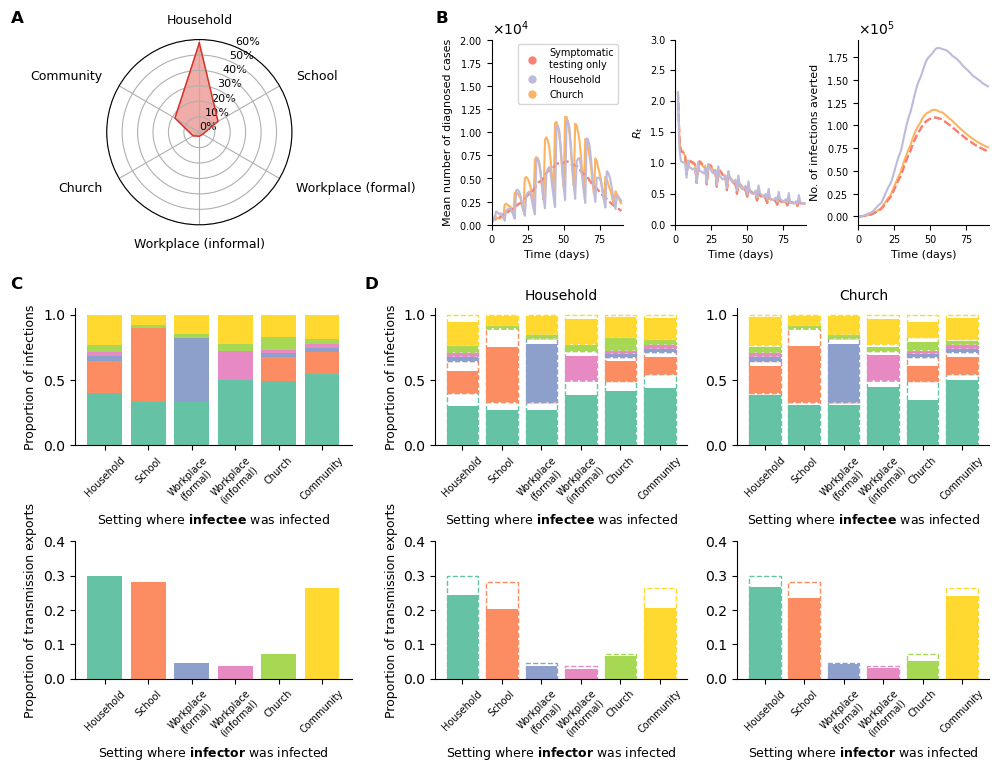

In [39]:
with plt.style.context('default'): 
    fig = plt.figure(figsize=(11.8, 8.3))
    gs = GridSpec(nrows=2, ncols=1, height_ratios=[1, 2], hspace=0.3)
    
    ###### 
    top_row_gs = gs[0].subgridspec(nrows=1, ncols=2, width_ratios=[1, 2], wspace=0.45)
    
    ### circular plot showing makeup of infections ### 
    ax = fig.add_subplot(top_row_gs[0], projection='polar')
    plot_6a(ax)
    
    ### example of household vs church ### 
    sub_top_row_gs = top_row_gs[1].subgridspec(nrows=1, ncols=3, wspace=0.4)
    plot_6b(sub_top_row_gs)
    
    ### plot spillover 
    btm_row_gs = gs[1].subgridspec(nrows=1, ncols=2, width_ratios=[1, 2])
    
    gs_6c = btm_row_gs[0].subgridspec(nrows=2, ncols=1, hspace=0.7)
    plot6c(gs_6c)
    
    gs_6d = btm_row_gs[1].subgridspec(nrows=2, ncols=2, hspace=0.7)
    plot_6d(gs_6d)
    
    fig.text(s=r'$\bf{A}$', x=0.07, y=.9, fontsize=12)
    fig.text(s=r'$\bf{B}$', x=0.43, y=.9, fontsize=12)
    fig.text(s=r'$\bf{C}$', x=0.07, y=.58, fontsize=12) 
    fig.text(s=r'$\bf{D}$', x=0.37, y=.58, fontsize=12)     
    
    plt.savefig('./manuscript/Figure7.png', dpi=330, bbox_inches='tight')
    plt.show()

## Global testing rate (Dec-2021 - Mar-2022)

In [36]:
import datetime as dt 

country_income_key = pd.read_csv("./data/FIND_test_data-2022-04-01.csv")
country_income_key = country_income_key.set_index("unit")[['income']].to_dict()['income']

test_data_df = pd.read_csv("./data/FIND_coronavirus_tests_2022-04-06.txt")
country_test_data_df = test_data_df[test_data_df['set']=="country"].copy()

country_test_data_df['income'] = country_test_data_df['unit'].map(country_income_key)
country_test_data_df['time'] = pd.to_datetime(country_test_data_df['time'])

country_test_data_df = country_test_data_df[~pd.isna(country_test_data_df['cap_new_tests'])]
country_test_data_df['cap_new_tests'] = country_test_data_df['cap_new_tests'] * 100
country_test_data_df = country_test_data_df[~pd.isna(country_test_data_df['income'])]

rt_df = pd.read_csv("./data/covid-rt-estimates_epiforecasts.txt")
rt_df['date'] = pd.to_datetime(rt_df['date'])
rt_df.loc[rt_df[rt_df['country']=="Congo - Kinshasa"].index, 'country'] = 'Democratic Republic of the Congo'
rt_df.loc[rt_df[rt_df['country']=="Congo - Brazzaville"].index, 'country'] = 'Republic of the Congo'
rt_df.loc[rt_df[rt_df['country']=="São Tomé & Príncipe"].index, 'country'] = 'Sao Tome and Principe'

date_range = pd.date_range('2020-01-01', '2022-04-01', freq='1M')

summary_test_df = []
for income in ['Low', 'Lower middle', 'Upper middle', 'High']: 
    income_fdf = country_test_data_df[country_test_data_df['income']==income]
    for country in income_fdf['unit'].unique(): 
        country_income_fdf = income_fdf[income_fdf['unit']==country].sort_values(by='time')
        country_name = country_income_fdf['name'].iloc[0]
        
        country_rt_df = rt_df[rt_df['country']==country_name]
        
        for d, date in enumerate(date_range): 
            if d == 0: 
                continue 
            prev_date = date_range[d-1]
            
            date_country_income_fdf = country_income_fdf[(country_income_fdf['time']>prev_date)&(country_income_fdf['time']<=date)]
            if len(date_country_income_fdf) == 0: 
                continue 
            
            mean_rt = None
            if len(country_rt_df) > 0: 
                date_country_rt_df = country_rt_df[(country_rt_df['date']>prev_date)&(country_rt_df['date']<=date)]
                if len(date_country_rt_df) > 0: 
                    mean_rt = date_country_rt_df['mean'].mean()
            
            summary_test_df.append({'income':income, 'country':country, 'country_name':country_name, 'month':date.month, 'year':date.year, 
                                    'tests/100k/day':date_country_income_fdf['cap_new_tests'].mean(), 
                                    'mean_rt':mean_rt})
summary_test_df = pd.DataFrame.from_dict(summary_test_df)
summary_test_df.head()

,income,country,country_name,month,year,tests/100k/day,mean_rt
0,Low,AFG,Afghanistan,3,2020,0.102359,NaN
1,Low,AFG,Afghanistan,4,2020,0.679374,NaN
2,Low,AFG,Afghanistan,5,2020,2.118386,NaN
3,Low,AFG,Afghanistan,6,2020,3.037659,NaN
4,Low,AFG,Afghanistan,7,2020,1.446923,NaN


In [37]:
lmic_summary_df = summary_test_df[summary_test_df['income'].isin(['Low', 'Lower middle'])]
lmic_summary_df['tests/100k/day'].mean()

29.414778493488253

/var/folders/tj/t8y9975d6_gd2b1hwc574cq80000gn/T/ipykernel_59920/2970005769.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["0.01", '0.1', '1', '10', '100', '1,000', '10,000', '100,000'])


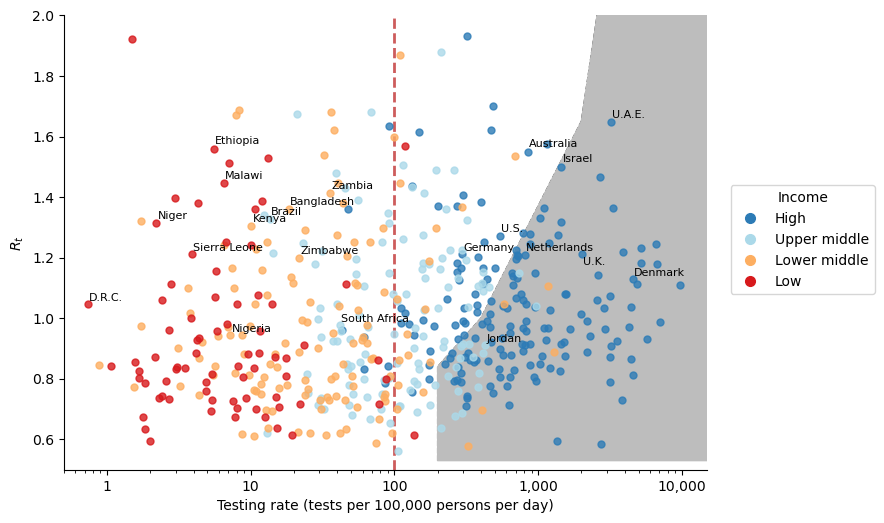

In [40]:
rt_summary_test_df = summary_test_df[~pd.isna(summary_test_df['mean_rt'])].copy()
rt_max_tests = pd.read_csv('./data/rt_max_tests.csv').set_index('Rt')
cmap = sns.color_palette('Greys', 4)

country_to_maxxy = {}

with plt.style.context('default'):
    fig, ax = plt.subplots(1, 1, figsize=(8.3, 11.8 * 0.5))
    for income, income_col in zip(['Low', 'Lower middle', 'Upper middle', 'High'][::-1], ['#d7191c','#fdae61','#abd9e9','#2c7bb6'][::-1]):
        income_fdf = rt_summary_test_df[rt_summary_test_df['income']==income]
        for country in income_fdf['country'].unique():
            country_income_fdf = income_fdf[income_fdf['country']==country]
            country_name = country_income_fdf['country_name'].iloc[0]
            
            y_arr = country_income_fdf['mean_rt'].to_numpy()
            x_arr = country_income_fdf['tests/100k/day'].to_numpy()
            
            country_to_maxxy[country_name] = (x_arr[np.where(y_arr == max(y_arr))[0]][0], y_arr[np.where(y_arr == max(y_arr))[0]][0])
            
            ax.scatter(x_arr, y_arr, color=income_col, marker='.', s=100, alpha=0.8, zorder=100)
            
    ax.set_xscale('log')
    ax.set_ylim(0.5, 2.0)
    ax.set_xlim(0.5, 1.5e4)
    
    for country in ['United States', 'United Kingdom', 'Denmark', 'Germany', "Netherlands", 'South Africa', 
                    'Democratic Republic of the Congo', 'Malawi', 'Ethiopia', 'Kenya', 'Nigeria', 'Zambia', 'Zimbabwe',
                    'Bangladesh', 'Australia', 'Brazil', 'Jordan', 'United Arab Emirates', 'Israel',
                    'Sierra Leone', 'Niger']: 
        xy = country_to_maxxy[country]
        #print (country, xy)
    
    #for country, xy in country_to_maxxy.items(): 
        if xy[0] > 1e4: 
            continue 
        if xy[-1] > 2: 
            continue 
            
        x=xy[0]*1.02 
        y=xy[-1]*1.01
        if country == 'United States': 
            country = 'U.S.'
        elif country == 'United Arab Emirates': 
            country = 'U.A.E.'
        elif country == 'United Kingdom': 
            country = 'U.K.'
            x=xy[0]*1.02
            y=xy[-1]*0.97
        elif country == 'Democratic Republic of the Congo': 
            country = 'D.R.C.'
            
        ax.text(x=x, y=y, s=country, fontsize=8, zorder=100)
    
    ax.plot(rt_max_tests['max_test'], rt_max_tests.index, color='#252525', ls='--', lw=1., zorder=0)
    ax.fill_betweenx(y=rt_max_tests.index, x1=rt_max_tests['max_test'], x2=1e6, color='#bdbdbd', zorder=0)    
    
    ax.axvline(100, ls='--', lw=2., zorder=0, color='indianred')
    
    #print (ax.get_yticks())
    ax.set_xticklabels(["0.01", '0.1', '1', '10', '100', '1,000', '10,000', '100,000'])
    ax.set_ylabel('$R_t$')
    ax.set_xlabel('Testing rate (tests per 100,000 persons per day)')
    for axis in ['top', 'right']: 
        ax.spines[axis].set_visible(False)
        
    # legend 
    legend_elements = []
    for income, income_col in zip(['Low', 'Lower middle', 'Upper middle', 'High'][::-1], ['#d7191c','#fdae61','#abd9e9','#2c7bb6'][::-1]):
        legend_elements.append(Line2D([0], [0], marker='o', color=income_col, lw=0., label=income, 
                                      markerfacecolor=income_col, markersize=7))
    legend = fig.legend(handles=legend_elements, bbox_to_anchor=(.92, 0.5), loc="center left", ncol=1, fontsize=10,
                        title='Income')
        
    plt.savefig('./manuscript/Figure8.png', dpi=330, bbox_inches='tight')
    plt.show()